In [51]:
import seaborn as sns
import os 
import numpy as np 
import pandas as pd 
from statsmodels.stats.anova import AnovaRM
import matplotlib.pyplot as plt
import pathlib as path
from scipy import stats

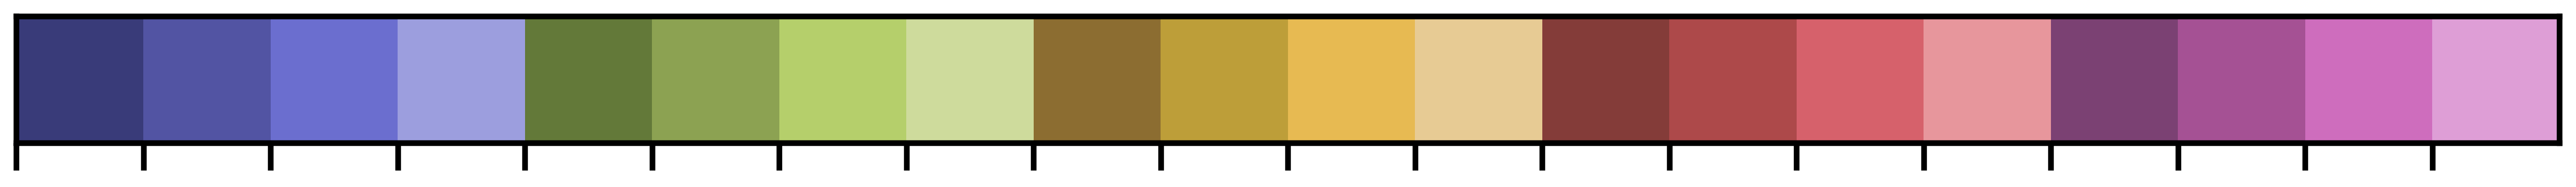

In [52]:
params = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 50,
    'axes.labelsize': 60,
    'axes.titlesize': 60,
    'xtick.labelsize': 50,
    'ytick.labelsize': 50,
    'legend.fontsize': 50,
    'lines.linewidth': 1,
    'figure.figsize': (30, 30),
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.format': 'svg',
    'savefig.bbox': 'tight'
}
plt.rcParams.update(params)

# Set Seaborn parameters
sns.set_context("poster", font_scale=1.0)
sns.set_palette('tab20b')

# Plot the color palette
sns.palplot(sns.color_palette())

# Choose a color from the palette
my_color = sns.color_palette()[2]

# Show the plot
plt.show()

In [53]:
#define the relevant path to the current batch you wish to parse
project_name='multicategory'
experiment_name='experiment 1'
qualification_method='loose' #or 'loose' or #'none' (will take the entire sample of participants that we have values for)

add_similarity_values=False #this adds the similarity of each image pair in the actuall experiment it takes some time (15 minutes)

model_name='VGG' #the only model we work with atm so dont change
PATH_TO_BATCH=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'collected data' 
PATH_TO_PROJECT=path.Path.cwd().parent.parent.parent / 'projects' / project_name 
PATH_TO_EXPERIMENT=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name
PATH_TO_OUTPUTS=path.Path.cwd().parent.parent.parent / 'projects' / project_name / experiment_name / 'figures and outputs' 
if PATH_TO_BATCH.exists():
    print('batch folder found at:\n' ,PATH_TO_BATCH)
else: 
    print('path to batch is non existent:\n',PATH_TO_BATCH)

batch folder found at:
 c:\Users\User\Desktop\visual_memory\visual_memory_representation_final\projects\multicategory\experiment 1\collected data


In [54]:
#PATH_TO_DATA = path.Path(r'C:\Users\User\Desktop\visualpilot')

all_directories_paths = [x[0] for x in os.walk(PATH_TO_BATCH) if 'batch' in x[0].split('\\')[-1] ]

#delete the following rows once batch 2 is actually filled with data and processed. 
all_directories_paths

['c:\\Users\\User\\Desktop\\visual_memory\\visual_memory_representation_final\\projects\\multicategory\\experiment 1\\collected data\\pilot_24_hours\\batch 1',
 'c:\\Users\\User\\Desktop\\visual_memory\\visual_memory_representation_final\\projects\\multicategory\\experiment 1\\collected data\\pilot_same_day\\batch 1',
 'c:\\Users\\User\\Desktop\\visual_memory\\visual_memory_representation_final\\projects\\multicategory\\experiment 1\\collected data\\pilot_same_day\\batch 2']

In [55]:

if qualification_method=='none':
    filename = 'one_line_per_participant_all_info_all_subject_strict.csv' #note that why i do use the "strict" its irrelevant as all_subjects includes all of th em and not just qualified so criterion is irrelevant for this line
elif qualification_method in ['strict','loose']:
    filename = 'one_line_per_participant_all_info_valid_subjects_only_'+qualification_method+'.csv'
else: 
    raise Exception(f'the qualification method choosen {qualification_method} is invalid')

all_valid_subjects = pd.DataFrame([])
for batch in all_directories_paths:
    time_gap = path.Path(batch).parent.name
    PATH_PROCESED = batch/path.Path(filename)
    file = pd.read_csv(PATH_PROCESED,index_col=0)
    file['time_gap'] = time_gap
    file['worker_ID'] = file.index 
    file['batch_number'] = int(path.Path(batch).name.split(' ')[-1])
    
    all_valid_subjects = pd.concat([all_valid_subjects,file])


In [56]:
all_valid_subjects.columns

Index(['demo_arrow_rt', 'demo_arrow_correct', 'demo_demo_accuracy',
       'demo_RT_overall_mean', 'demo_rating_varience',
       'demo_RT_incorrect_mean', 'demo_RT_correct_mean',
       'encoding_arrow_mean_rt', 'encoding_arrow_accuracy',
       'testing_Test_overall_accuracy', 'testing_RT_overall_mean',
       'testing_rating_varience', 'testing_rating_mean',
       'testing_layer_1_rating', 'testing_layer_3_rating',
       'testing_RT_incorrect_mean', 'testing_RT_correct_mean',
       'testing_layer_1_rt', 'testing_layer_1_accuracy', 'testing_layer_3_rt',
       'testing_layer_3_accuracy', 'testing_longest_response_strike',
       'time_gap', 'worker_ID', 'batch_number'],
      dtype='object')

In [57]:
#n_one_week= all_valid_subjects['time_gap'].value_counts()['pilot_one_week']
n_24_hours= all_valid_subjects['time_gap'].value_counts()['pilot_24_hours']
n_same_day= all_valid_subjects['time_gap'].value_counts()['pilot_same_day']

all_valid_subjects['time_gap'].value_counts()

time_gap
pilot_same_day    49
pilot_24_hours    15
Name: count, dtype: int64

lets check if there are duplicate subject names , if so we drop one of there rows 

In [58]:
print(f'there are {len(all_valid_subjects.index) - len(set(all_valid_subjects.index))}, duplicate subjects')

there are 1, duplicate subjects


In [59]:
all_valid_subjects = all_valid_subjects[~((all_valid_subjects['worker_ID'] == 'AEK2SAEL9GG39') & (all_valid_subjects['time_gap'] == 'pilot_24_hours')) ]

In [60]:
all_valid_subjects.columns

Index(['demo_arrow_rt', 'demo_arrow_correct', 'demo_demo_accuracy',
       'demo_RT_overall_mean', 'demo_rating_varience',
       'demo_RT_incorrect_mean', 'demo_RT_correct_mean',
       'encoding_arrow_mean_rt', 'encoding_arrow_accuracy',
       'testing_Test_overall_accuracy', 'testing_RT_overall_mean',
       'testing_rating_varience', 'testing_rating_mean',
       'testing_layer_1_rating', 'testing_layer_3_rating',
       'testing_RT_incorrect_mean', 'testing_RT_correct_mean',
       'testing_layer_1_rt', 'testing_layer_1_accuracy', 'testing_layer_3_rt',
       'testing_layer_3_accuracy', 'testing_longest_response_strike',
       'time_gap', 'worker_ID', 'batch_number'],
      dtype='object')

In [61]:
#create long format dataframes for accuracy and rt seperately
rt_df = pd.melt(all_valid_subjects,id_vars=['worker_ID','time_gap'],value_vars=['testing_layer_1_rt','testing_layer_3_rt'],var_name='layer')
accuracy_df = pd.melt(all_valid_subjects,id_vars=['worker_ID','time_gap'],value_vars=['testing_layer_1_accuracy','testing_layer_3_accuracy'],var_name='layer')
rating_df = pd.melt(all_valid_subjects,id_vars=['worker_ID','time_gap'],value_vars=['testing_layer_1_rating','testing_layer_3_rating'],var_name='layer')

In [62]:
all_valid_subjects.to_csv(PATH_TO_OUTPUTS / ('all_data_for_spss_analysis_'+qualification_method+' .csv'),index=False,)

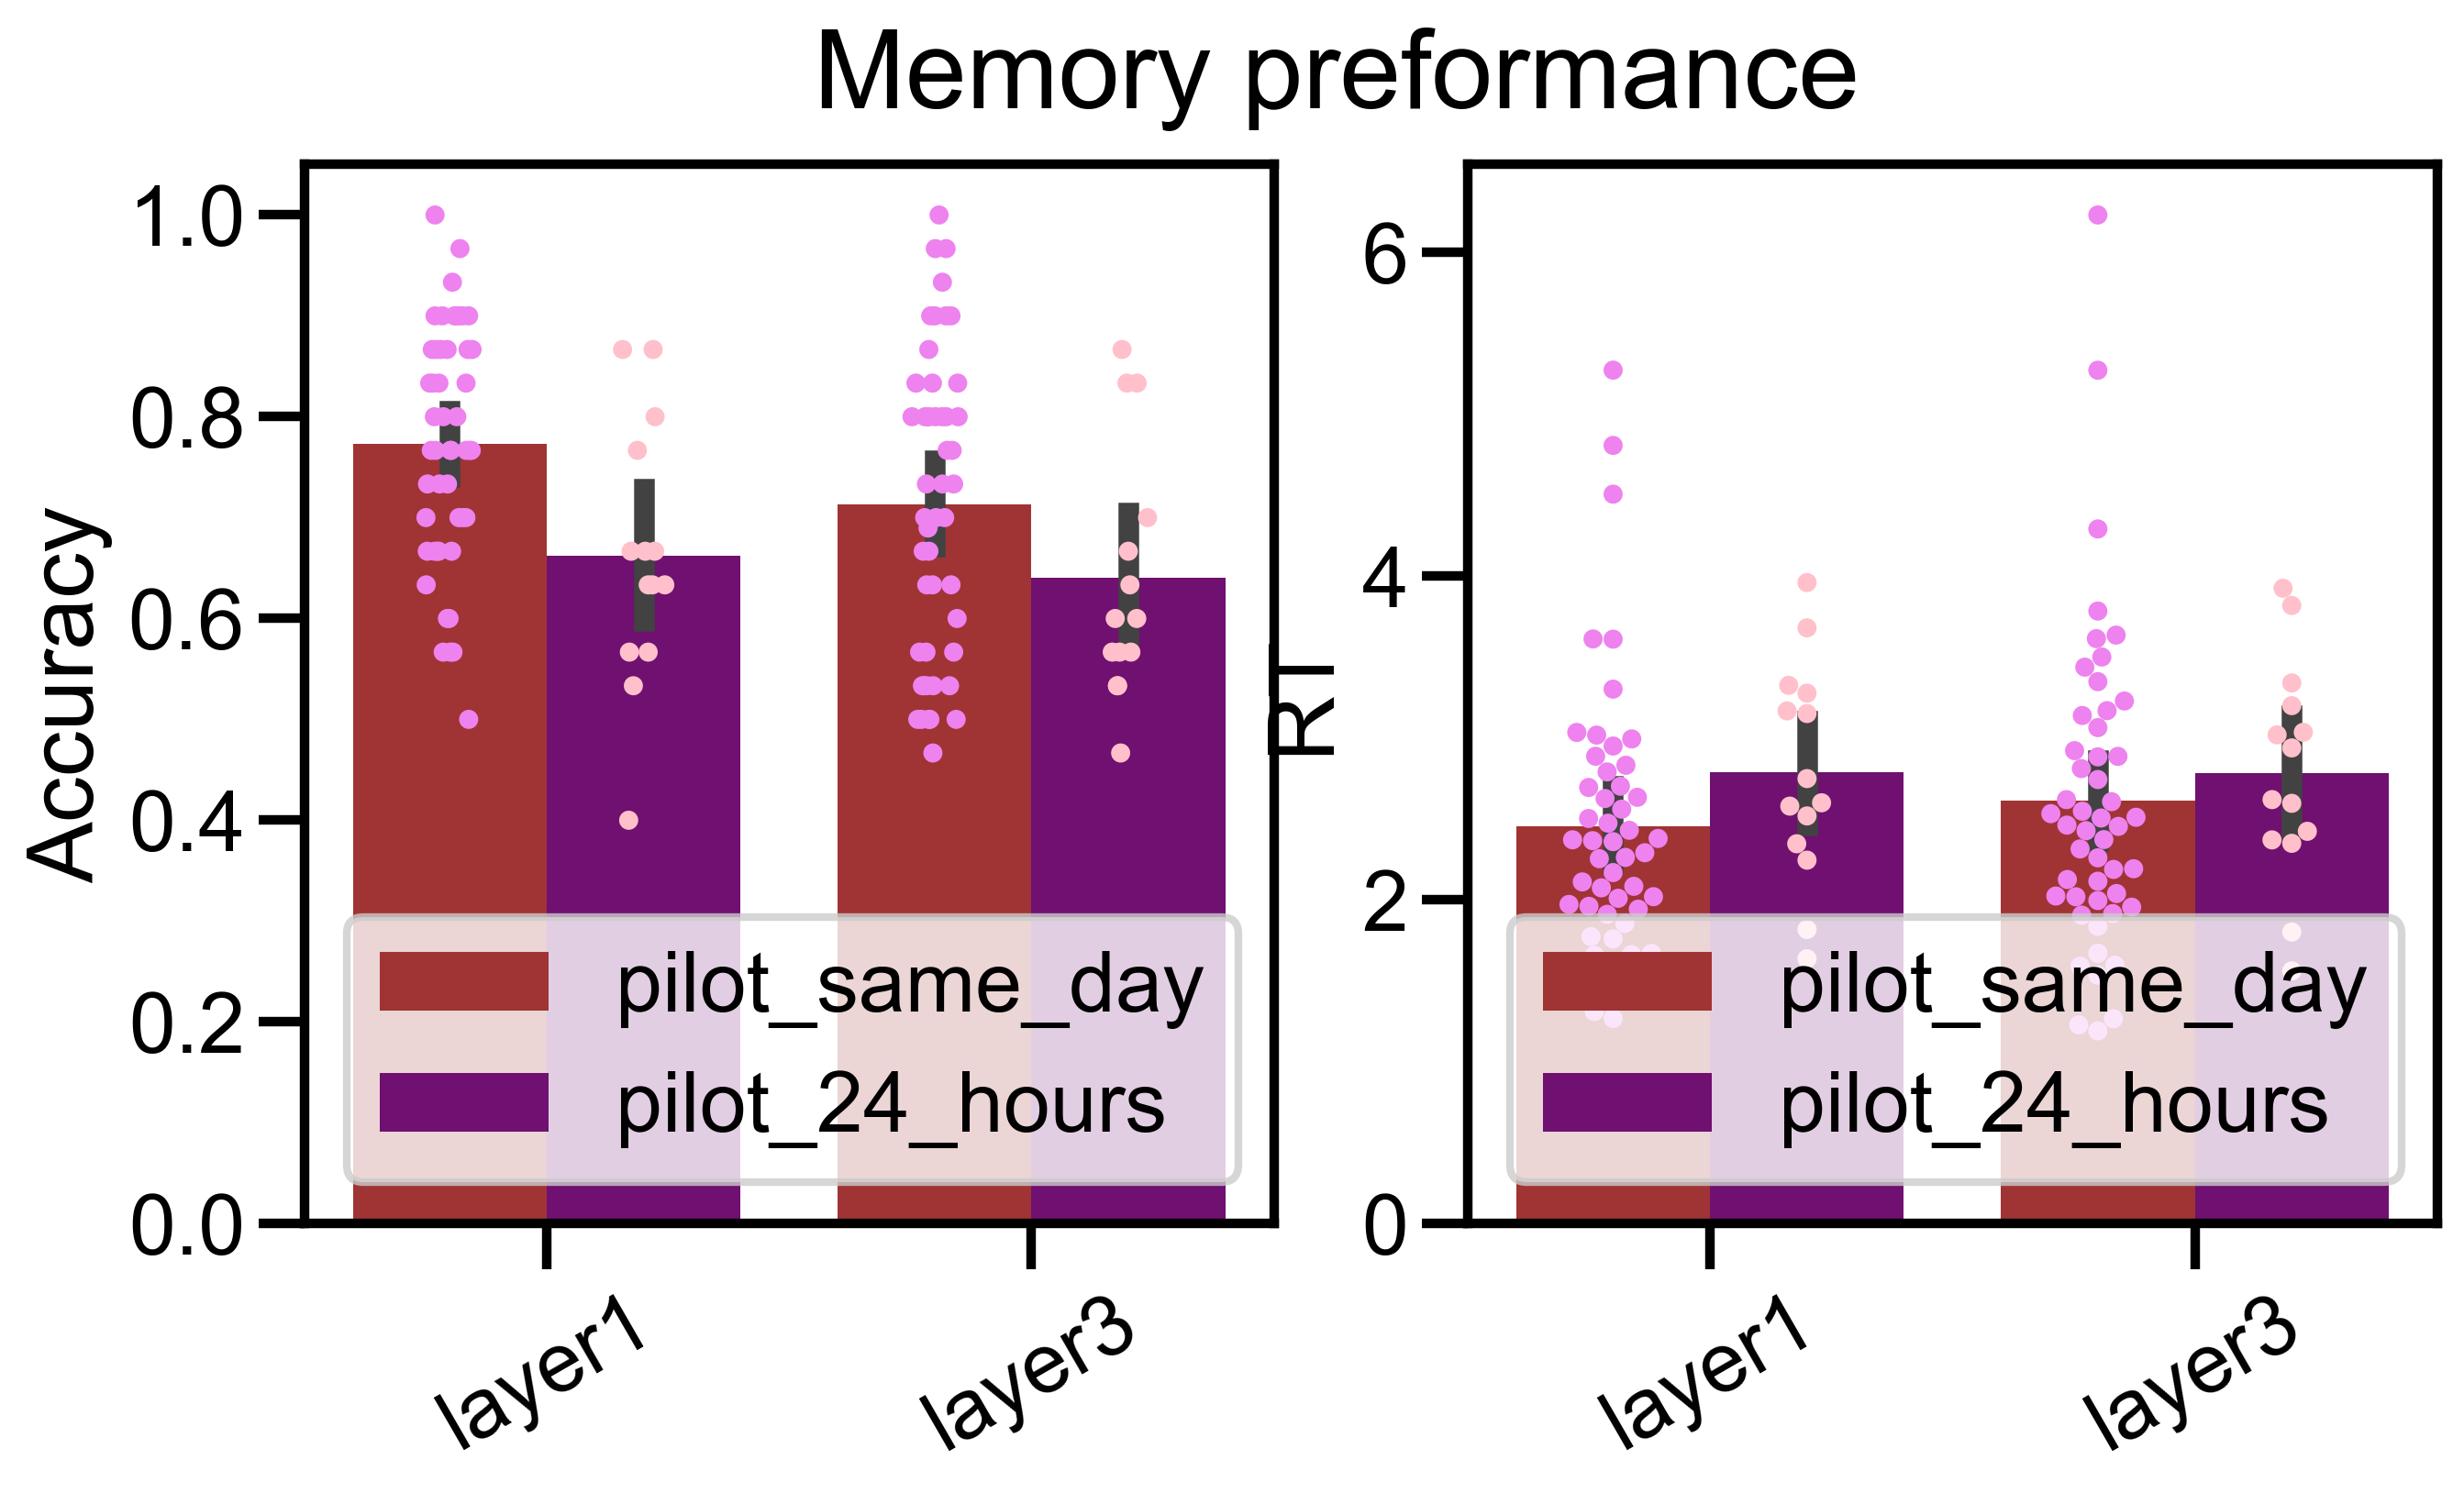

In [63]:


my_order = ['pilot_same_day','pilot_24_hours','pilot_one_week']
my_order = ['pilot_same_day','pilot_24_hours']

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#sns.barplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],palette={'pilot_same_day':'firebrick','pilot_24_hours':'purple','pilot_one_week':'green'},hue_order=my_order)
#sns.stripplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],dodge=True,palette={'pilot_same_day':'violet','pilot_24_hours':'pink','pilot_one_week':'blue'},jitter=True,hue_order=my_order)

sns.barplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],palette={'pilot_same_day':'firebrick','pilot_24_hours':'purple'},hue_order=my_order)
sns.stripplot(data =accuracy_df, x='layer',y='value',hue='time_gap',ax=axes[0],dodge=True,palette={'pilot_same_day':'violet','pilot_24_hours':'pink'},jitter=True,hue_order=my_order)



axes[0].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[0].set_xlabel('')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[2:],labels[2:],loc='lower left')
axes[0].set_ylabel('Accuracy')


sns.barplot(data =rt_df, x='layer',y='value',hue='time_gap',ax=axes[1],palette={'pilot_same_day':'firebrick','pilot_24_hours':'purple'},hue_order=my_order)
sns.swarmplot(data =rt_df, x='layer',y='value',hue='time_gap',ax=axes[1],palette={'pilot_same_day':'violet','pilot_24_hours':'pink'},dodge=True,hue_order=my_order)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].set_xticklabels(labels=['layer1','layer3'],rotation=30)
axes[1].legend(handles[2:],labels[2:],loc='lower left')
axes[1].set_ylabel('RT')
axes[1].set_xlabel('')

fig.suptitle('Memory preformance')

fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_layer_'+qualification_method+'.svg'))


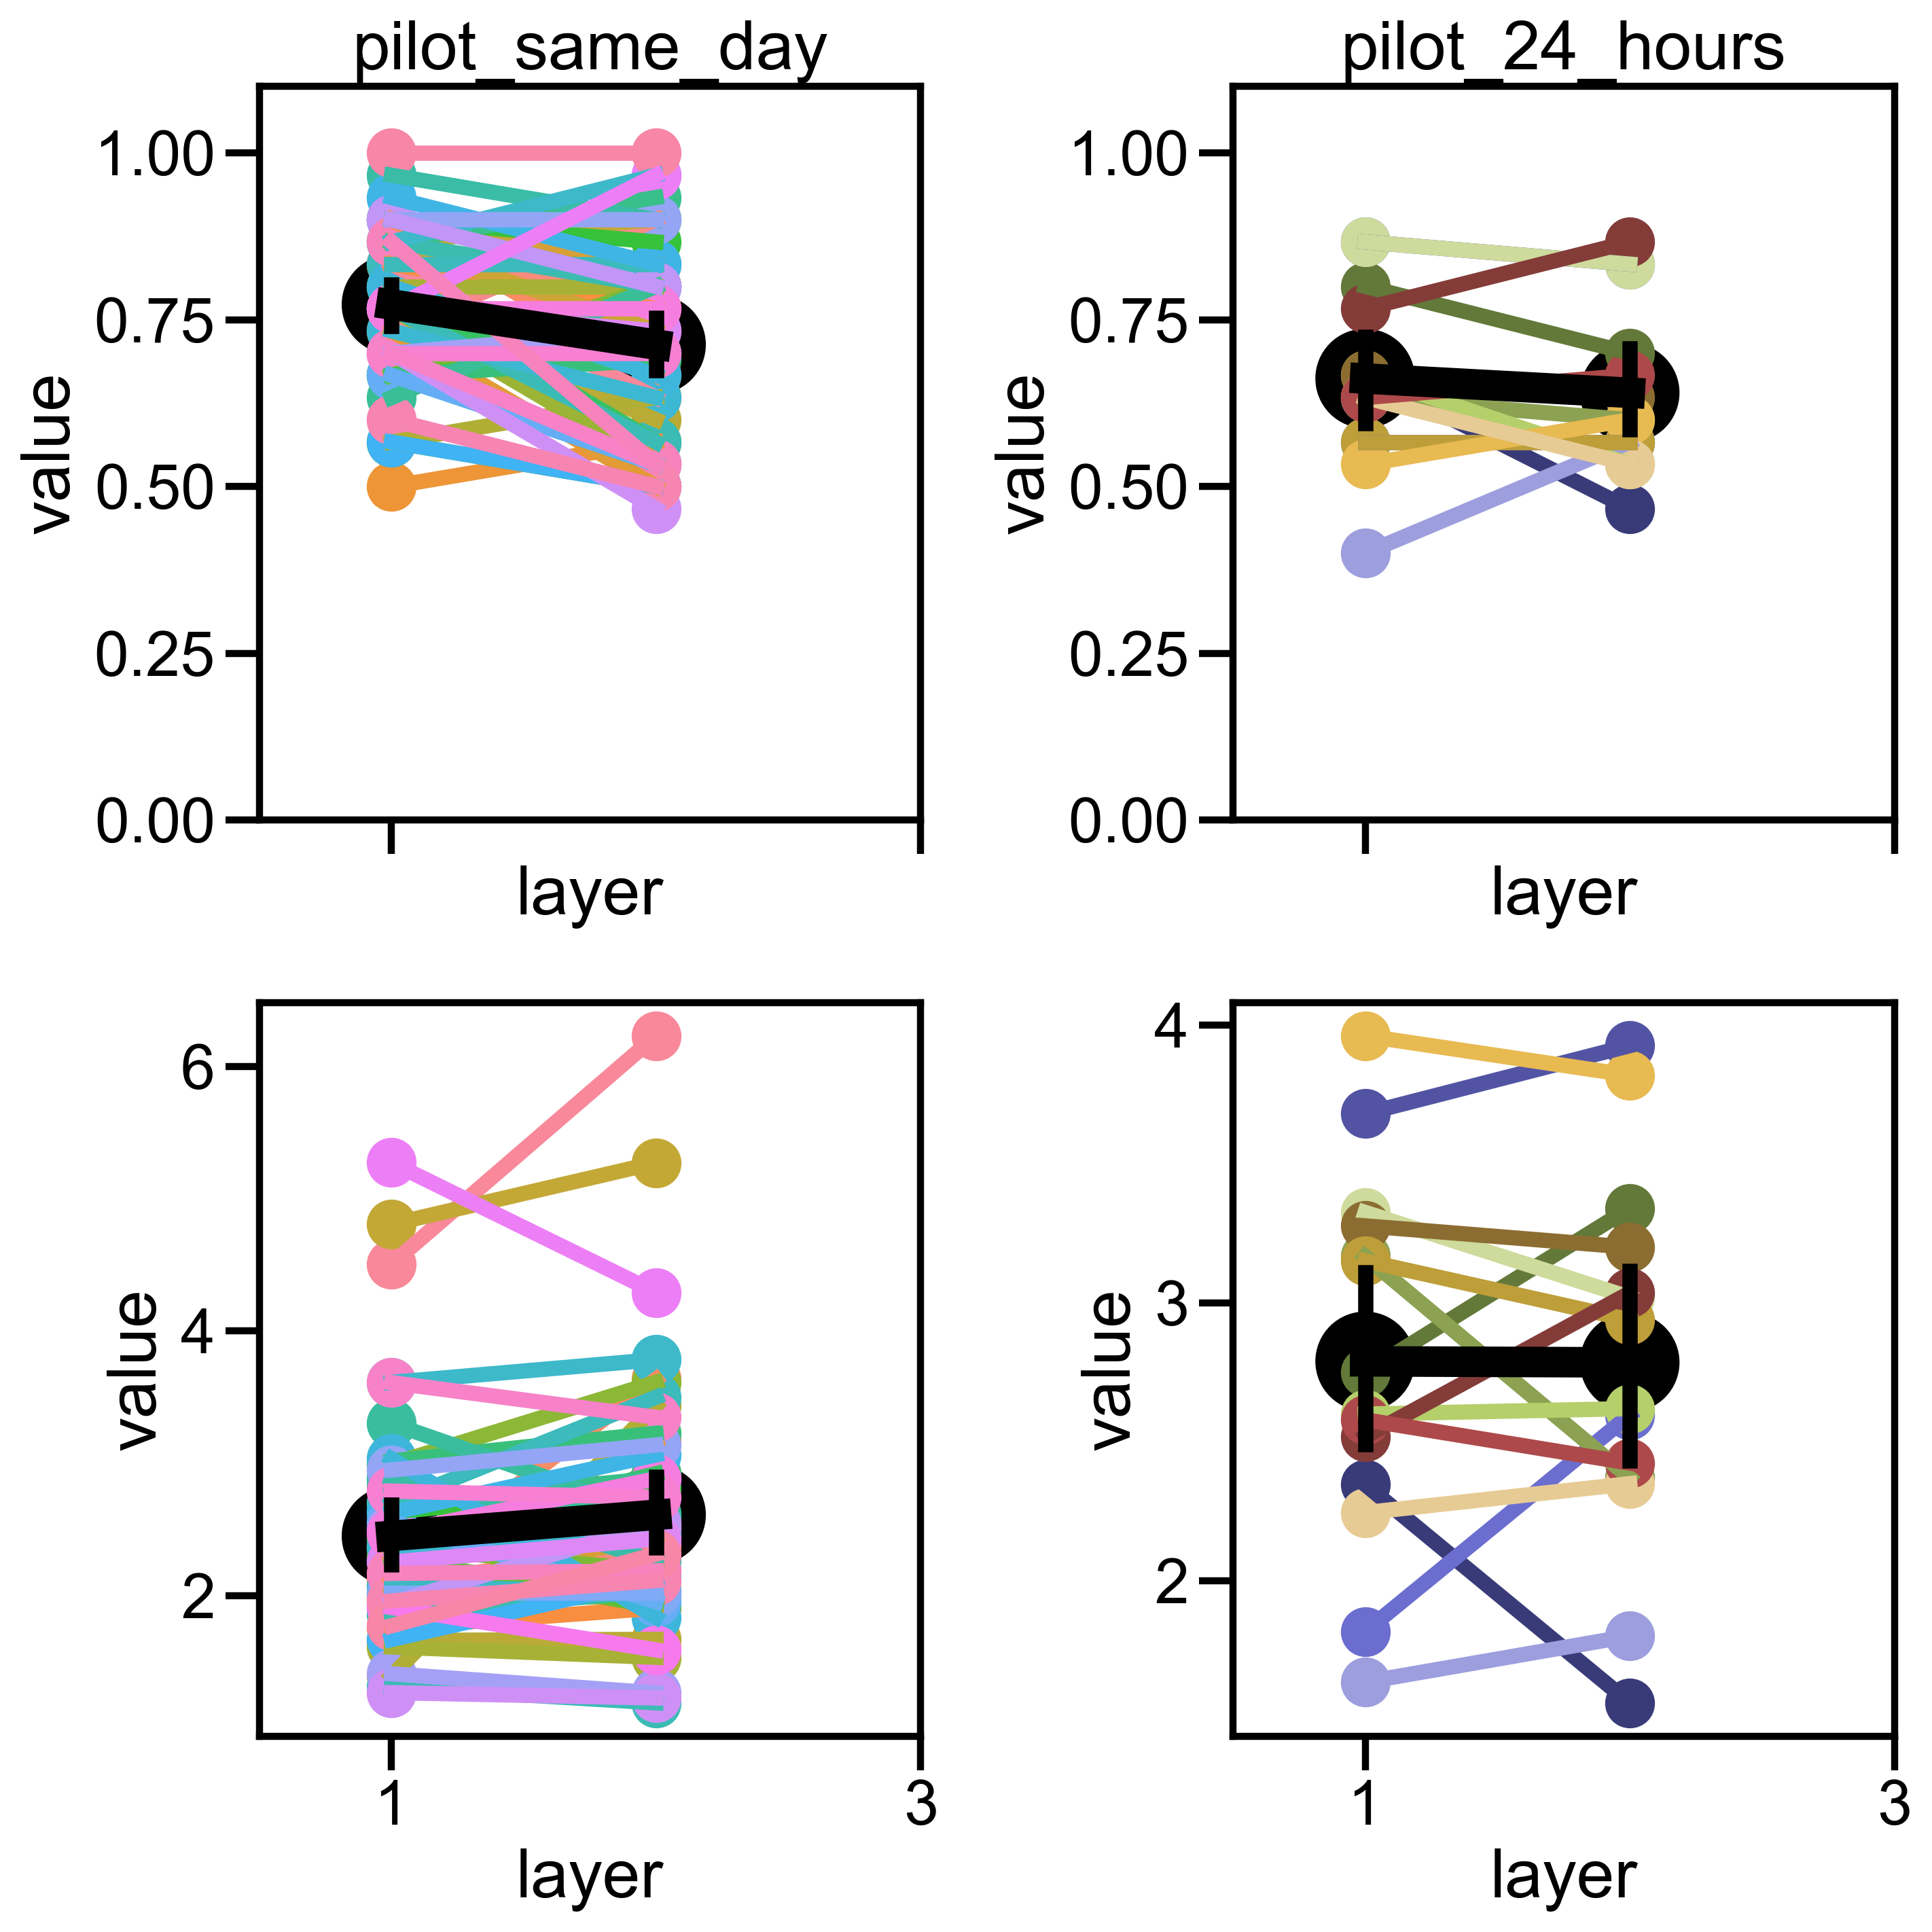

In [64]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharex=True,sharey=False)

for i,curtime in enumerate(my_order):
    #accuracy: 
    g=sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[0,i])
    plt.setp(axes[0,i].lines, zorder=100)
    axes[0,i].set_ylim([0,1.1])
    sns.pointplot(data=accuracy_df[accuracy_df['time_gap']==curtime],x='layer', y='value',ax=axes[0,i],color='black',scale=2)
    plt.setp(axes[0,i].lines, zorder=200)
    axes[0,i].get_legend().remove() 
    axes[0,i].set_title(curtime)
    #rt: 
    g=sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value', hue='worker_ID', ax=axes[1,i])
    plt.setp(axes[1,i].lines, zorder=100)
    sns.pointplot(data=rt_df[rt_df['time_gap']==curtime],x='layer', y='value',ax=axes[1,i],color='black',scale=2)
    plt.setp(axes[1,i].lines, zorder=200)
    plt.xticks([0,2],['1','3'])
    axes[1,i].get_legend().remove()

plt.tight_layout()
fig.savefig(PATH_TO_EXPERIMENT / ('line_graphs_per_condition_in_seperate_subplots_'+qualification_method+'.svg'))


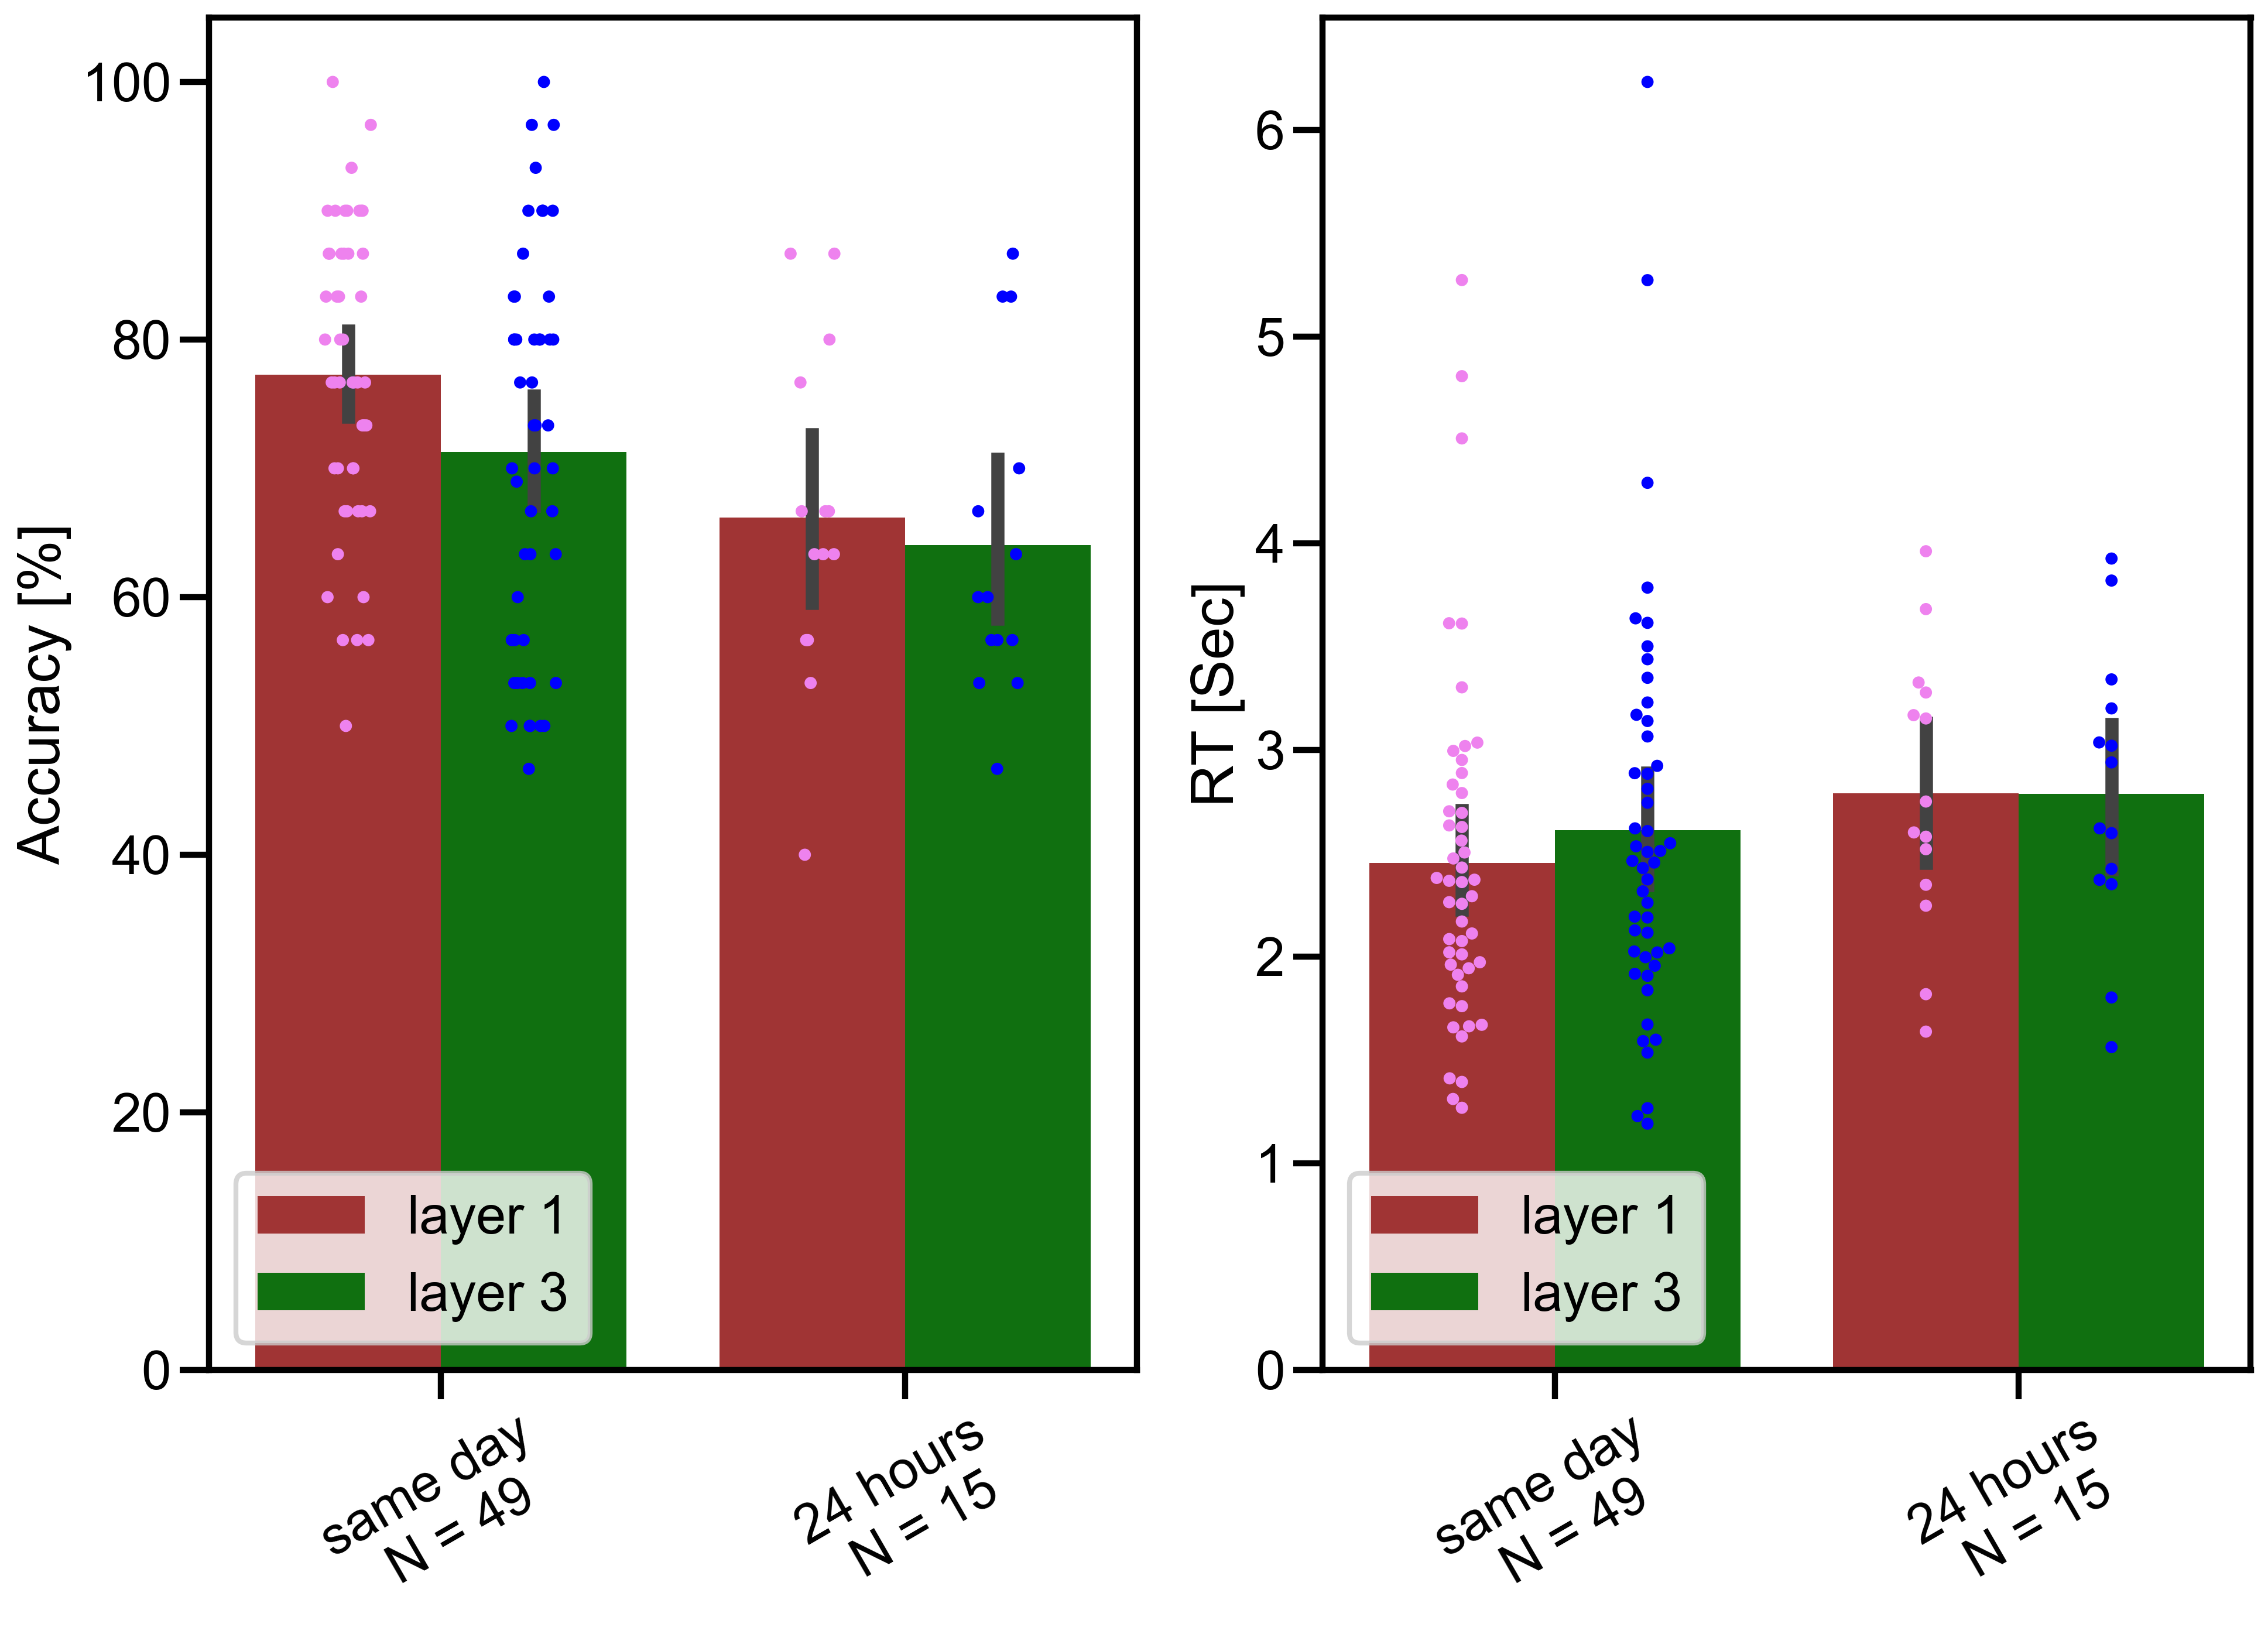

In [65]:
#code for figures:
my_order = ['testing_layer_1_accuracy','testing_layer_3_accuracy']

if accuracy_df['value'].mean()<1:
    accuracy_df['value']=accuracy_df['value']*100

fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(15,10),gridspec_kw = {'wspace':0.2, 'hspace':0})
bar = sns.barplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes[0],palette={'testing_layer_1_accuracy':'firebrick','testing_layer_3_accuracy':'green'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
sns.stripplot(data =accuracy_df, x='time_gap',y='value',hue='layer',ax=axes[0],dodge=True,palette={'testing_layer_1_accuracy':'violet','testing_layer_3_accuracy':'blue'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
# axes[0].set_xticklabels(labels=['pilot_same_day','pilot_24_hours','pilot_one_week'],rotation=30)
axes[0].set_xlabel('')
axes[0].set_xticklabels(labels=[f'same day\n N = {n_same_day}',f'24 hours\n N = {n_24_hours}'],rotation=30)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles[2:],['layer 1','layer 3'],loc='lower left')
axes[0].set_ylabel('Accuracy [%]')



my_order = ['testing_layer_1_rt','testing_layer_3_rt']

sns.barplot(data =rt_df, x='time_gap',y='value',hue='layer',ax=axes[1],palette={'testing_layer_1_rt':'firebrick','testing_layer_3_rt':'green'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
sns.swarmplot(data =rt_df,x='time_gap',y='value',hue='layer',ax=axes[1],palette={'testing_layer_1_rt':'violet','testing_layer_3_rt':'blue'},dodge=True,hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].set_xticklabels(labels=[f'same day\n N = {n_same_day}',f'24 hours\n N = {n_24_hours}'],rotation=30)
axes[1].legend(handles[2:],['layer 1','layer 3'],loc='lower left')
axes[1].set_ylabel('RT [Sec]')
axes[1].set_xlabel('')

#fig.tight_layout()
#fig.suptitle('Memory preformance')
fig.savefig(PATH_TO_EXPERIMENT / ('all_batches_bar_graph_grouped_by_timegap_'+qualification_method+'.svg'))


In [66]:
# lets look at the std 
for layer in np.unique(accuracy_df['layer'].values):
    curr_df = accuracy_df[accuracy_df['layer'] == layer]
    curr_vals = curr_df['value']
    layer_num = layer.split('_')[-2]
    print(f'the std for layer {layer_num} is {curr_vals.values.std()}')

    for time in np.unique(curr_df['time_gap'].values):

        curr_vals_time = curr_df[curr_df['time_gap'] == time]['value'] 
        print(f'the std for layer {layer_num} and time gap: {time} is {curr_vals_time.values.std()}')



the std for layer 1 is 12.693341138922309
the std for layer 1 and time gap: pilot_24_hours is 12.526615655205626
the std for layer 1 and time gap: pilot_same_day is 11.618920166899631
the std for layer 3 is 14.605115211580271
the std for layer 3 and time gap: pilot_24_hours is 12.030290568247414
the std for layer 3 and time gap: pilot_same_day is 14.876419705597538


## this section creates a long dataformat for all participants from the 3 possible time gaps
### cells running additional analyses on this long format: 
* checks how position in the encoding stream effects performence 
* creates a multi level logistic regression that examine the contribution of the similarity levels between each pair across the 3 defined levels



In [67]:
#read data from all time gaps: 

all_participants_results_files=list(set([sub_path.parent.parent for sub_path in list(PATH_TO_EXPERIMENT.rglob('*.csv')) if '-' in sub_path.name]))
#remove the sameday batches that are not 6 or 7
all_participants_batch_locations= all_participants_results_files
all_participants_batch_locations

[WindowsPath('c:/Users/User/Desktop/visual_memory/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_24_hours/batch 1'),
 WindowsPath('c:/Users/User/Desktop/visual_memory/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 2'),
 WindowsPath('c:/Users/User/Desktop/visual_memory/visual_memory_representation_final/projects/multicategory/experiment 1/collected data/pilot_same_day/batch 1')]

In [68]:
#create a long format encoding and test dataframes: 
all_subjects_encoding_long_format_df=pd.DataFrame()
all_subjects_test_long_format_df=pd.DataFrame()
for cur_batch in all_participants_batch_locations:
    cur_sub_encoding_df=pd.read_csv(cur_batch / 'all_subjects_encoding_df.csv')
    cur_sub_test_df=pd.read_csv(cur_batch / 'all_subjects_test_df.csv')

    cur_sub_encoding_df['time_gap']=cur_batch.parent.name
    cur_sub_test_df['time_gap']=cur_batch.parent.name

    all_subjects_encoding_long_format_df=pd.concat([all_subjects_encoding_long_format_df,cur_sub_encoding_df],axis=0)
    all_subjects_test_long_format_df=pd.concat([all_subjects_test_long_format_df,cur_sub_test_df],axis=0)


all_valid_test_df_long_format=pd.DataFrame()
all_valid_encoding_df_long_format=pd.DataFrame()

for cur_sub in all_valid_subjects.index:
    #some subject names are the full length name to thier csv: if this is the case, change it to take only the amazong worker id: 
    cur_sub_encoding=all_subjects_encoding_long_format_df[all_subjects_encoding_long_format_df['subject']==cur_sub]
    cur_sub_test=all_subjects_test_long_format_df[all_subjects_test_long_format_df['subject']==cur_sub]
    all_valid_encoding_df_long_format=pd.concat([all_valid_encoding_df_long_format,cur_sub_encoding],axis=0)
    all_valid_test_df_long_format=pd.concat([all_valid_test_df_long_format,cur_sub_test],axis=0)

print('only valid participants counts:')
print(all_valid_test_df_long_format['time_gap'].value_counts())
print('all participants counts:')
print(all_subjects_test_long_format_df['time_gap'].value_counts())


only valid participants counts:
time_gap
pilot_same_day    2940
pilot_24_hours     900
Name: count, dtype: int64
all participants counts:
time_gap
pilot_same_day    5280
pilot_24_hours    1800
Name: count, dtype: int64


In [69]:
"""
#create a dataframe which allows the analysis of encoding position: 

images_position_accuracy_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])
target_images=set(all_valid_encoding_df_long_format['target'].unique())-{'left.jpg','right.jpg'}
for cur_img in target_images:
     
    img_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])
    cur_encoding_img_info=all_valid_encoding_df_long_format[all_valid_encoding_df_long_format['target']==cur_img]
    img_df['target_layer']=cur_encoding_img_info['layer'].values
    img_df['serial_position_in_encoding']=cur_encoding_img_info['trials.thisTrialN'].values
    img_df['viewed_by_encoding']= cur_encoding_img_info['subject'].values
    img_df['img_name']=cur_img
    img_df['time_gap']=cur_encoding_img_info['time_gap'].values
    #get from test: 
    cur_test_img_info=all_valid_test_df_long_format[(all_valid_test_df_long_format['image1']==cur_img) | (all_valid_test_df_long_format['image2']==cur_img)]

    img_df['distractor_layer']=cur_test_img_info['layer'].values
    img_df['is_correct']=cur_test_img_info['test_test_response.corr'].values
    img_df['distractor_side']=cur_test_img_info['correct'].values
    img_df['viewed_by_test']=cur_test_img_info['subject'].values

    images_position_accuracy_df=pd.concat([images_position_accuracy_df,img_df],axis=0)
#remember to change left to right and right to left: """


"\n#create a dataframe which allows the analysis of encoding position: \n\nimages_position_accuracy_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])\ntarget_images=set(all_valid_encoding_df_long_format['target'].unique())-{'left.jpg','right.jpg'}\nfor cur_img in target_images:\n     \n    img_df=pd.DataFrame(columns=['img_name','target_layer','distractor_layer','serial_position_in_encoding','is_correct','viewed_by_encoding','viewed_by_test','distractor_side','time_gap'])\n    cur_encoding_img_info=all_valid_encoding_df_long_format[all_valid_encoding_df_long_format['target']==cur_img]\n    img_df['target_layer']=cur_encoding_img_info['layer'].values\n    img_df['serial_position_in_encoding']=cur_encoding_img_info['trials.thisTrialN'].values\n    img_df['viewed_by_encoding']= cur_encoding_img_info['subject'].values\n    img_df['img_name']=cur_img\n    img_d

In [70]:
"""#create a plot for each time gap, X is target image serial position in encoding, y is the average accuracy (this analysis probably needs alot of data)
grouped_df=images_position_accuracy_df.groupby(['time_gap','distractor_layer','serial_position_in_encoding']).aggregate({'is_correct':['mean','std']})
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(20,10),sharex=True,sharey=True)
for i,cur_timegap in enumerate(['pilot_same_day','pilot_24_hours','pilot_one_week']):
    grouped_df.loc[cur_timegap, 1.0]['is_correct', 'mean'].plot(ax=axes[i],color='r')
    grouped_df.loc[cur_timegap, 2.0]['is_correct', 'mean'].plot(ax=axes[i],color='b')
    grouped_df.loc[cur_timegap, 3.0]['is_correct', 'mean'].plot(ax=axes[i],color='g')
    axes[i].set_title(cur_timegap)
    axes[i].set_xlabel('encoding serial position')
    axes[i].set_ylabel('accuracy [Mean]')"""



"#create a plot for each time gap, X is target image serial position in encoding, y is the average accuracy (this analysis probably needs alot of data)\ngrouped_df=images_position_accuracy_df.groupby(['time_gap','distractor_layer','serial_position_in_encoding']).aggregate({'is_correct':['mean','std']})\nfig,axes=plt.subplots(nrows=3,ncols=1,figsize=(20,10),sharex=True,sharey=True)\nfor i,cur_timegap in enumerate(['pilot_same_day','pilot_24_hours','pilot_one_week']):\n    grouped_df.loc[cur_timegap, 1.0]['is_correct', 'mean'].plot(ax=axes[i],color='r')\n    grouped_df.loc[cur_timegap, 2.0]['is_correct', 'mean'].plot(ax=axes[i],color='b')\n    grouped_df.loc[cur_timegap, 3.0]['is_correct', 'mean'].plot(ax=axes[i],color='g')\n    axes[i].set_title(cur_timegap)\n    axes[i].set_xlabel('encoding serial position')\n    axes[i].set_ylabel('accuracy [Mean]')"

In [71]:
#here we do some statistics: mixed effects (1 between (time gap - 3 levels) and 1 within factors (layer representation - 3 levels)) and some assumption checks
import pingouin as pg

#check for sphercity assumption" 
print('\n---sphericity assumption----------')
print(pg.sphericity(data=accuracy_df, dv='value', subject='worker_ID', within='layer')[-1])

#homoscedasticity
print('\n---homoscedasticity assumption---')
for layer_val in accuracy_df['layer'].unique():
    print(f'layer: {layer_val}:')
    print(pg.homoscedasticity(accuracy_df[accuracy_df['layer']==layer_val], dv='value', group='time_gap'))



#assumption of normality: 
print('\n-----normality assumption-------')
accuracy_df['factor_comb']=accuracy_df["layer"] + '_'+accuracy_df["time_gap"]
print(pg.normality(accuracy_df, dv='value', group='factor_comb'))


print('\n---------anova results----------')

print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=accuracy_df))




---sphericity assumption----------
1.0

---homoscedasticity assumption---
layer: testing_layer_1_accuracy:
               W      pval  equal_var
levene  0.001001  0.974869       True
layer: testing_layer_3_accuracy:
               W      pval  equal_var
levene  2.032375  0.159077       True

-----normality assumption-------
                                                W      pval  normal
factor_comb                                                        
testing_layer_1_accuracy_pilot_24_hours  0.948236  0.533676    True
testing_layer_1_accuracy_pilot_same_day  0.968922  0.219311    True
testing_layer_3_accuracy_pilot_24_hours  0.889743  0.080147    True
testing_layer_3_accuracy_pilot_same_day  0.947658  0.029717   False

---------anova results----------
        Source           SS  DF1  DF2           MS          F     p-unc   
0     time_gap  1825.726139    1   61  1825.726139   6.258187  0.015061  \
1        layer   835.035556    1   61   835.035556  13.106884  0.000600   
2  Int

# RATING ANALYSIS 

In [72]:

#check for sphercity assumption" 
print('\n---sphericity assumption----------')
print(pg.sphericity(data=rating_df, dv='value', subject='worker_ID', within='layer')[-1])

#homoscedasticity
print('\n---homoscedasticity assumption---')
for layer_val in rating_df['layer'].unique():
    print(f'layer: {layer_val}:')
    print(pg.homoscedasticity(rating_df[rating_df['layer']==layer_val], dv='value', group='time_gap'))



#assumption of normality: 
print('\n-----normality assumption-------')
rating_df['factor_comb']=rating_df["layer"] + '_'+rating_df["time_gap"]
print(pg.normality(rating_df, dv='value', group='factor_comb'))


print('\n---------anova results----------')

print(pg.mixed_anova(dv='value', between='time_gap', within='layer', subject='worker_ID', data=rating_df))



---sphericity assumption----------
1.0

---homoscedasticity assumption---
layer: testing_layer_1_rating:
         W  pval  equal_var
levene NaN   NaN      False
layer: testing_layer_3_rating:
         W  pval  equal_var
levene NaN   NaN      False

-----normality assumption-------
                                              W      pval  normal
factor_comb                                                      
testing_layer_1_rating_pilot_24_hours  0.950651  0.570856    True
testing_layer_1_rating_pilot_same_day  0.962984  0.188682    True
testing_layer_3_rating_pilot_24_hours  0.964617  0.797732    True
testing_layer_3_rating_pilot_same_day  0.962997  0.188879    True

---------anova results----------
        Source         SS  DF1  DF2         MS          F         p-unc   
0     time_gap  13.325761    1   54  13.325761   3.582269  6.376443e-02  \
1        layer   6.582844    1   54   6.582844  39.648963  5.680850e-08   
2  Interaction   0.024125    1   54   0.024125   0.145309  7.0

Text(0, 0.5, 'Rating')

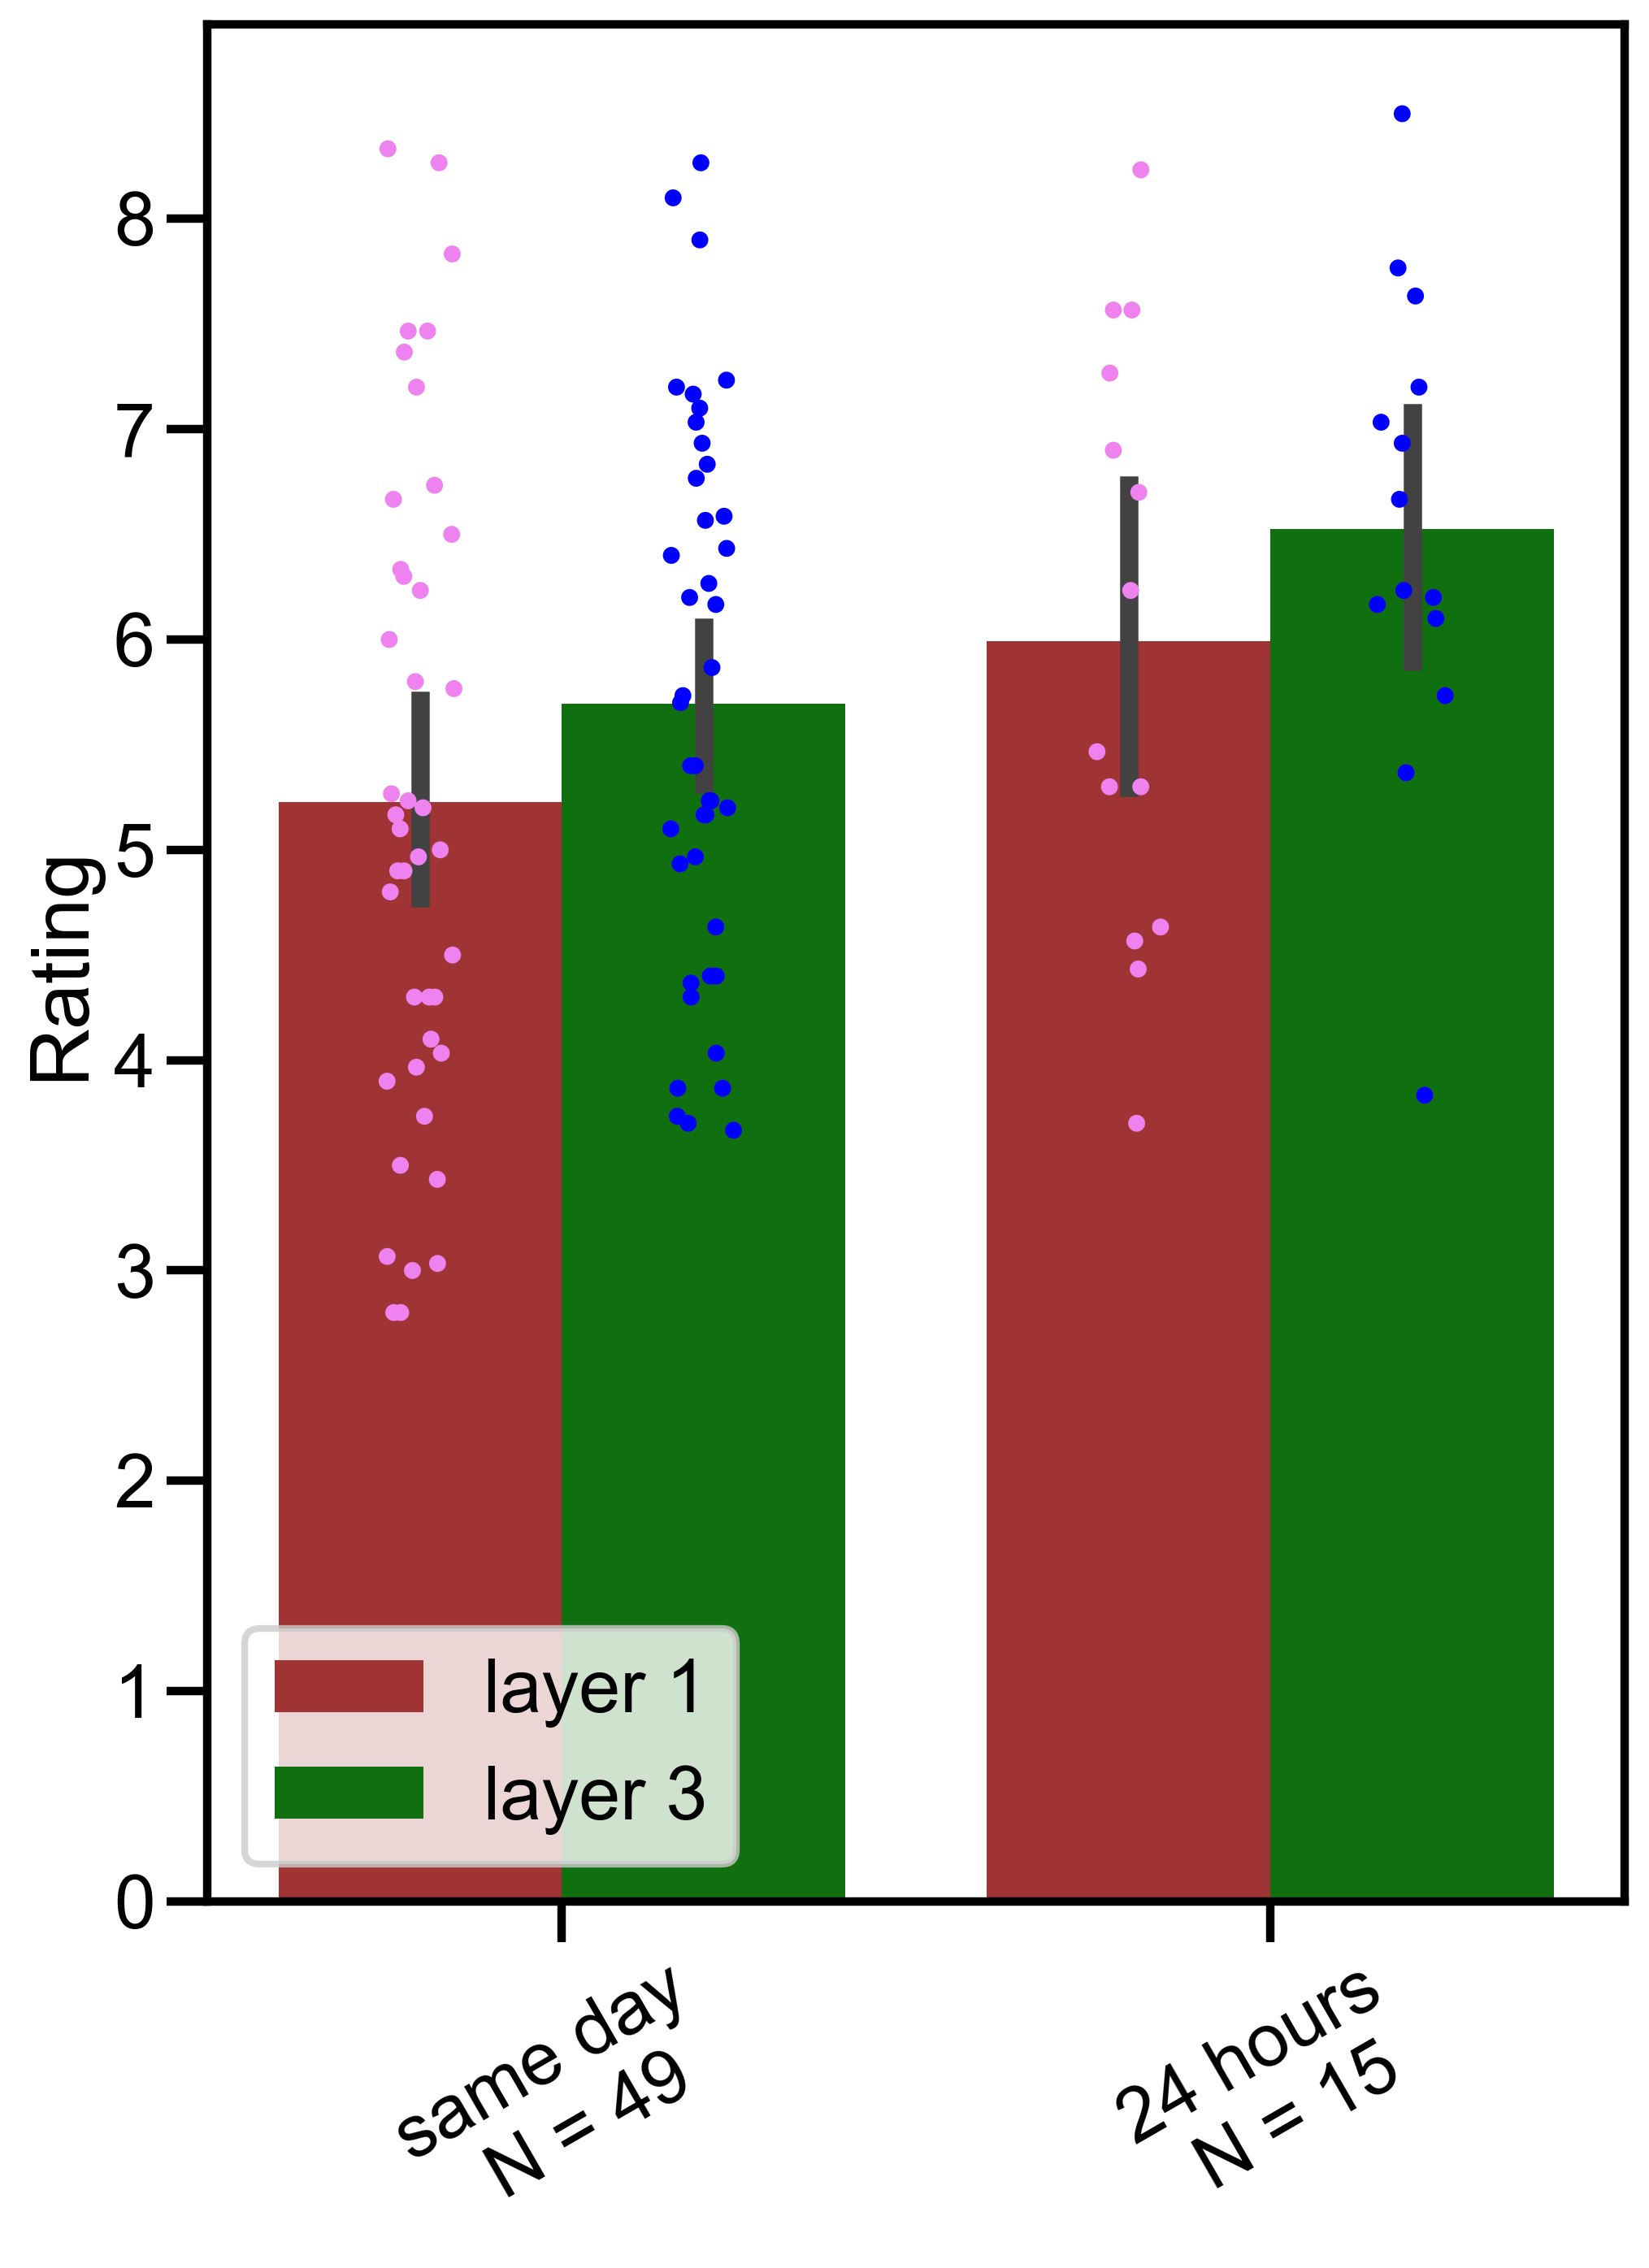

In [74]:
my_order = ['testing_layer_1_rating','testing_layer_3_rating']

fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(7.5,10),gridspec_kw = {'wspace':0.2, 'hspace':0})
bar = sns.barplot(data =rating_df, x='time_gap',y='value',hue='layer',ax=axes,palette={'testing_layer_1_rating':'firebrick','testing_layer_3_rating':'green'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
sns.stripplot(data =rating_df, x='time_gap',y='value',hue='layer',ax=axes,dodge=True,palette={'testing_layer_1_rating':'violet','testing_layer_3_rating':'blue'},hue_order=my_order,order=['pilot_same_day','pilot_24_hours'])
# axes[0].set_xticklabels(labels=['pilot_same_day','pilot_24_hours','pilot_one_week'],rotation=30)
axes.set_xlabel('')
axes.set_xticklabels(labels=[f'same day\n N = {n_same_day}',f'24 hours\n N = {n_24_hours}'],rotation=30)
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles[2:],['layer 1','layer 3'],loc='lower left')
axes.set_ylabel('Rating')



In [75]:
simillarity_df = pd.DataFrame([])
for cat in ['badlands','bridge','golf_course','highway','mountain','playground']:
    filename = f'similarity_between_pairs_VGG{cat}.csv'
    PATH_TO_PROJECT = PATH_TO_BATCH.parent.parent
    cur_similarity_df = pd.read_csv(PATH_TO_PROJECT/filename)
    simillarity_df = pd.concat([simillarity_df,cur_similarity_df])


simillarity_df['image1'] = simillarity_df['image1'].str.replace('.pkl','.jpg')
simillarity_df['image2'] = simillarity_df['image2'].str.replace('.pkl','.jpg')


# sort the values in each row
temp1 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = simillarity_df[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
simillarity_df['image1']=temp1
simillarity_df['image2']=temp2


temp1 = all_valid_test_df_long_format[['image1', 'image2']].apply(lambda x: sorted(x)[0], axis=1)
temp2 = all_valid_test_df_long_format[['image1', 'image2']].apply(lambda x: sorted(x)[1], axis=1)
all_valid_test_df_long_format['image1']=temp1
all_valid_test_df_long_format['image2']=temp2


all_subjects_test_df=pd.merge(simillarity_df, all_valid_test_df_long_format, on=['image1', 'image2'],how='right')


all_subjects_test_df = all_subjects_test_df.rename(columns={"test_test_response.corr": "corr", "bar_2.response": "bar_2"})
all_subjects_test_df['mean_sim']=all_subjects_test_df[[col for col in all_subjects_test_df.columns if 'level_' in col]].mean(axis=1)
all_subjects_test_df['mean_sim_0_6']=all_subjects_test_df[['level_0','level_6']].mean(axis=1)

In [76]:
all_subjects_test_df

,image1,image2,level_0,level_1,level_2,level_3,level_4,level_5,level_6,model,...,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,trials_2.ran,bar_2,subject,time_gap,mean_sim,mean_sim_0_6
0,playground_137.jpg,playground_144.jpg,0.425595,0.335114,0.247312,0.183824,0.141902,0.201654,0.115837,VGG,...,0.0,0.0,0.0,0.0,1.0,7.0,A27KTNOX292J1I,pilot_24_hours,0.235891,0.270716
1,badlands_1.jpg,badlands_21.jpg,0.497682,0.415034,0.290335,0.219225,0.234978,0.351705,0.324851,VGG,...,0.0,1.0,1.0,1.0,1.0,8.0,A27KTNOX292J1I,pilot_24_hours,0.333401,0.411266
2,bridge_163.jpg,bridge_172.jpg,0.240999,0.294224,0.232784,0.197814,0.179835,0.533336,0.719496,VGG,...,0.0,2.0,2.0,2.0,1.0,8.0,A27KTNOX292J1I,pilot_24_hours,0.342641,0.480247
3,badlands_102.jpg,badlands_70.jpg,0.500617,0.400207,0.290936,0.264759,0.331024,0.486013,0.435829,VGG,...,0.0,3.0,3.0,3.0,1.0,8.0,A27KTNOX292J1I,pilot_24_hours,0.387055,0.468223
4,playground_117.jpg,playground_127.jpg,0.353457,0.293740,0.206282,0.164136,0.188968,0.548600,0.633445,VGG,...,0.0,4.0,4.0,4.0,1.0,4.0,A27KTNOX292J1I,pilot_24_hours,0.341232,0.493451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,golf_course_217.jpg,golf_course_262.jpg,0.268017,0.286801,0.206212,0.199519,0.196874,0.521599,0.684805,VGG,...,0.0,55.0,55.0,55.0,1.0,3.0,A24GX1OZE6AY04,pilot_same_day,0.337690,0.476411
3836,badlands_24.jpg,badlands_3.jpg,0.474635,0.374899,0.295967,0.279708,0.225719,0.373287,0.308845,VGG,...,0.0,56.0,56.0,56.0,1.0,2.0,A24GX1OZE6AY04,pilot_same_day,0.333294,0.391740
3837,highway_273.jpg,highway_384.jpg,0.613053,0.392409,0.304938,0.328729,0.351532,0.583315,0.542290,VGG,...,0.0,57.0,57.0,57.0,1.0,3.0,A24GX1OZE6AY04,pilot_same_day,0.445181,0.577672
3838,highway_174.jpg,highway_415.jpg,0.282304,0.237405,0.199127,0.169243,0.217185,0.575302,0.740489,VGG,...,0.0,58.0,58.0,58.0,1.0,4.0,A24GX1OZE6AY04,pilot_same_day,0.345865,0.511396


In [77]:
df_24_hours = all_subjects_test_df[all_subjects_test_df['time_gap'] == 'pilot_24_hours']
df_same_day = all_subjects_test_df[all_subjects_test_df['time_gap'] == 'pilot_same_day']

df_24_hours_grouped = df_24_hours.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})
df_same_day_grouped = df_same_day.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})

correlations_df_24_hours_grouped=df_24_hours.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})
correlations_df_same_day_grouped=df_same_day.groupby(['image1','image2']).aggregate({'bar_2':'mean','level_0':'mean','level_6':'mean','mean_sim':'mean','corr':'mean'})

In [78]:
df_24_hours_grouped = df_24_hours_grouped.drop(('bridge_17.jpg','bridge_172.jpg'))
df_same_day_grouped = df_same_day_grouped.drop(('bridge_17.jpg','bridge_172.jpg'))

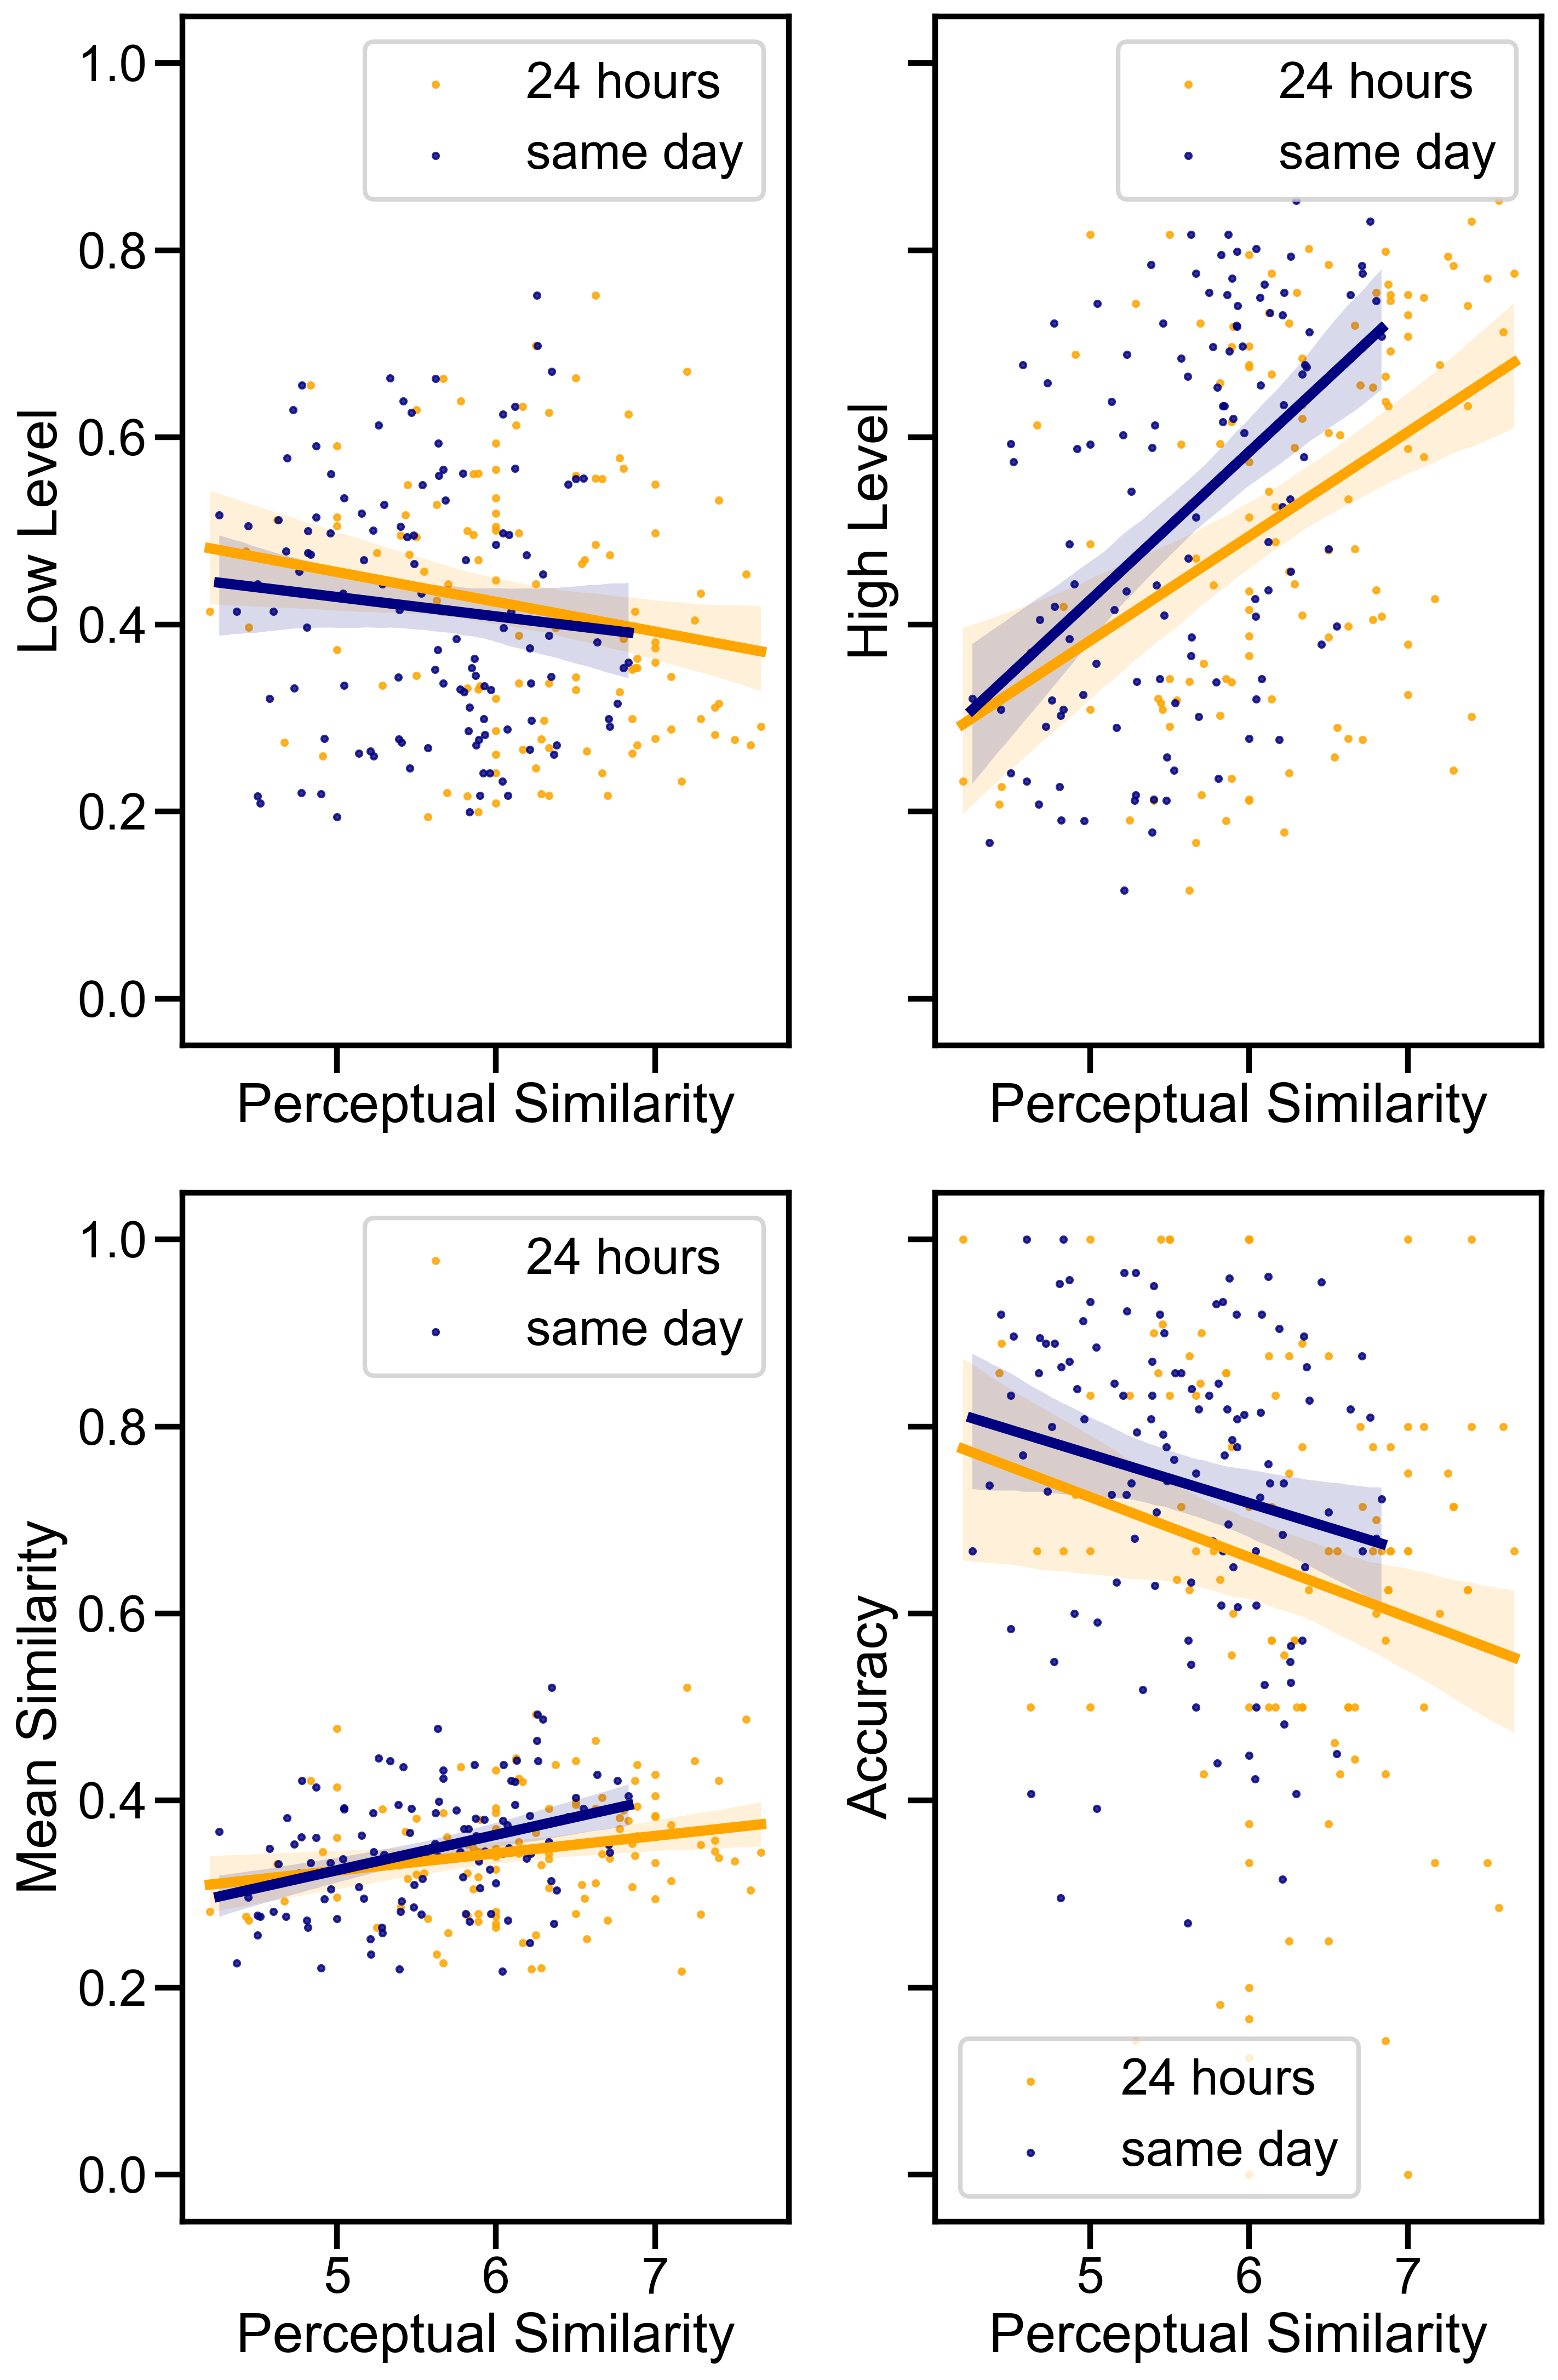

In [96]:
fig,axes=plt.subplots(nrows=2,ncols=2,sharex = True,sharey = True,figsize=(10,15))
axes=axes.ravel()
# low level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['bar_2'], y=correlations_df_24_hours_grouped['level_0'])
sns.regplot(data=df_24_hours_grouped,x='bar_2',y='level_0',ax=axes[0],color = 'orange',label = f'24 hours',scatter_kws={'s':7})
#axes[0].set_title(f'perceptual similarity\nand low level similarity')

#rho={r_value_24:.3f}\np={p_value_24:.3f}



slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['bar_2'], y=correlations_df_same_day_grouped['level_0'])
sns.regplot(data=df_same_day_grouped,x='bar_2',y='level_0',ax=axes[0],color = 'navy',label = f'same day',scatter_kws={'s':7})
axes[0].set_xlabel('Perceptual Similarity')
axes[0].set_ylabel('Low Level')
axes[0].legend()
#\nrho={r_value_day:.3f}\np={p_value_day:.3f}

# high level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['bar_2'], y=correlations_df_24_hours_grouped['level_6'])
sns.regplot(data=df_24_hours_grouped,x='bar_2',y='level_6',ax=axes[1],color = 'orange',label = f'24 hours',scatter_kws={'s':7})
#axes[1].set_title(f'perceptual similarity\nand high level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['bar_2'], y=correlations_df_same_day_grouped['level_6'])
sns.regplot(data=df_same_day_grouped,x='bar_2',y='level_6',ax=axes[1],color = 'navy',label = f'same day',scatter_kws={'s':7})
axes[1].set_xlabel('Perceptual Similarity')
axes[1].set_ylabel('High Level')
axes[1].legend()

# mean similarity
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['bar_2'], y=correlations_df_24_hours_grouped['mean_sim'])
sns.regplot(data=df_24_hours_grouped,x='bar_2',y='mean_sim',ax=axes[2],color = 'orange',label = f'24 hours',scatter_kws={'s':7})
#axes[2].set_title(f'perceptual similarity\nand low level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['bar_2'], y=correlations_df_same_day_grouped['mean_sim'])
sns.regplot(data=df_same_day_grouped,x='bar_2',y='mean_sim',ax=axes[2],color = 'navy',label = f'same day',scatter_kws={'s':7})
axes[2].set_xlabel('Perceptual Similarity')
axes[2].set_ylabel('Mean Similarity')
axes[2].legend()

# corr
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['bar_2'], y=correlations_df_24_hours_grouped['corr'])
sns.regplot(data=df_24_hours_grouped,x='bar_2',y='corr',ax=axes[3],color = 'orange',label = f'24 hours',scatter_kws={'s':7})
#axes[3].set_title(f'perceptual similarity\nand accuracy')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['bar_2'], y=correlations_df_same_day_grouped['corr'])
sns.regplot(data=df_same_day_grouped,x='bar_2',y='corr',ax=axes[3],color = 'navy',label = f'same day',scatter_kws={'s':7})
axes[3].set_xlabel('Perceptual Similarity')
axes[3].set_ylabel('Accuracy')
axes[3].legend()
fig.tight_layout()

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load example dataset
tips = sns.load_dataset("tips")
plt.figure(figsize=(10,10))
# Plot a regression line with stretched x-axis
sns.regplot(data=tips, x="total_bill", y="tip")
plt.xlim(0, 100)

# Show the plot
plt.show()

MemoryError: 

<Figure size 9000x9000 with 1 Axes>

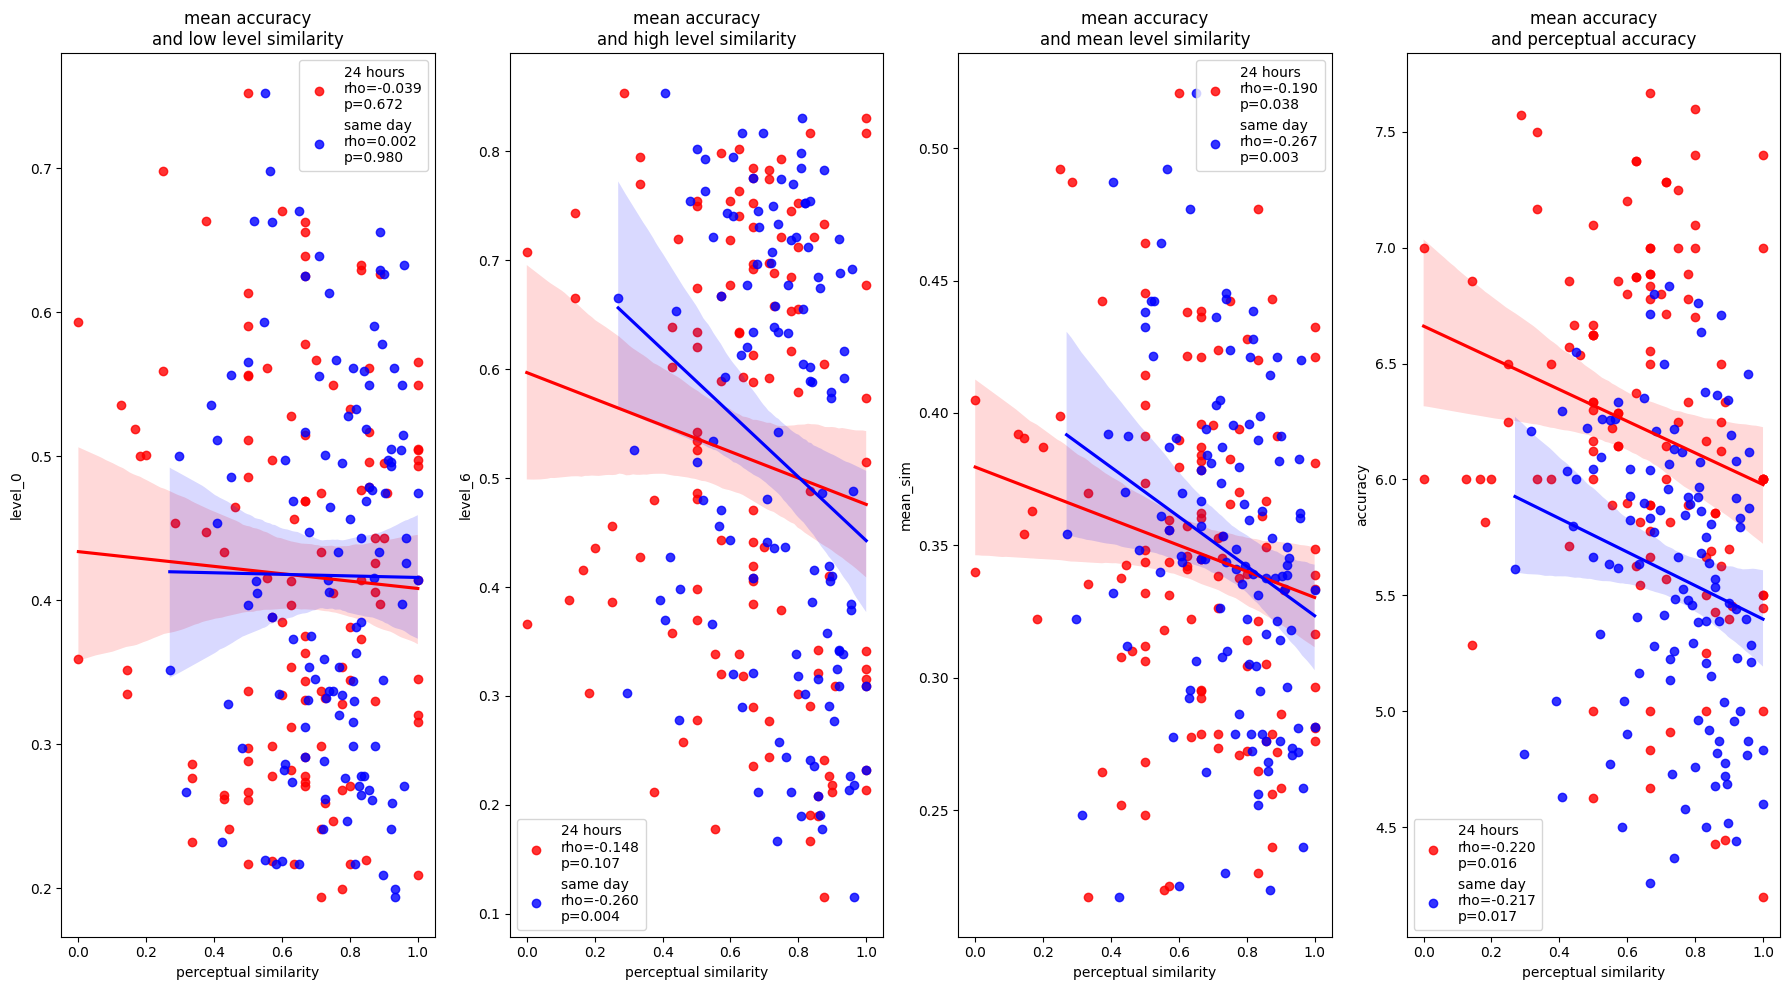

In [280]:
fig,axes=plt.subplots(nrows=1,ncols=4,figsize=(18,10))
# low level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['corr'], y=correlations_df_24_hours_grouped['level_0'])
sns.regplot(data=df_24_hours_grouped,x='corr',y='level_0',ax=axes[0],color = 'red',label = f'24 hours\nrho={r_value_24:.3f}\np={p_value_24:.3f}')
axes[0].set_title(f'mean accuracy\nand low level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['corr'], y=correlations_df_same_day_grouped['level_0'])
sns.regplot(data=df_same_day_grouped,x='corr',y='level_0',ax=axes[0],color = 'blue',label = f'same day\nrho={r_value_day:.3f}\np={p_value_day:.3f}')
axes[0].set_xlabel('perceptual similarity')
axes[0].legend()

# high level
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['corr'], y=correlations_df_24_hours_grouped['level_6'])
sns.regplot(data=df_24_hours_grouped,x='corr',y='level_6',ax=axes[1],color = 'red',label = f'24 hours\nrho={r_value_24:.3f}\np={p_value_24:.3f}')
axes[1].set_title(f'mean accuracy\nand high level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['corr'], y=correlations_df_same_day_grouped['level_6'])
sns.regplot(data=df_same_day_grouped,x='corr',y='level_6',ax=axes[1],color = 'blue',label = f'same day\nrho={r_value_day:.3f}\np={p_value_day:.3f}')
axes[1].set_xlabel('perceptual similarity')
axes[1].legend()

# mean similarity
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['corr'], y=correlations_df_24_hours_grouped['mean_sim'])
sns.regplot(data=df_24_hours_grouped,x='corr',y='mean_sim',ax=axes[2],color = 'red',label = f'24 hours\nrho={r_value_24:.3f}\np={p_value_24:.3f}')
axes[2].set_title(f'mean accuracy\nand mean level similarity')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['corr'], y=correlations_df_same_day_grouped['mean_sim'])
sns.regplot(data=df_same_day_grouped,x='corr',y='mean_sim',ax=axes[2],color = 'blue',label = f'same day\nrho={r_value_day:.3f}\np={p_value_day:.3f}')
axes[2].set_xlabel('perceptual similarity')
axes[2].legend()

# corr
slope_24, intercept_24, r_value_24, p_value_24, std_err_24 = stats.linregress(x=correlations_df_24_hours_grouped['corr'], y=correlations_df_24_hours_grouped['bar_2'])
sns.regplot(data=df_24_hours_grouped,x='corr',y='bar_2',ax=axes[3],color = 'red',label = f'24 hours\nrho={r_value_24:.3f}\np={p_value_24:.3f}')
axes[3].set_title(f'mean accuracy\nand perceptual accuracy')

slope_day, intercept_day, r_value_day, p_value_day, std_err_day = stats.linregress(x=correlations_df_same_day_grouped['corr'], y=correlations_df_same_day_grouped['bar_2'])
sns.regplot(data=df_same_day_grouped,x='corr',y='bar_2',ax=axes[3],color = 'blue',label = f'same day\nrho={r_value_day:.3f}\np={p_value_day:.3f}')
axes[3].set_xlabel('perceptual similarity')
axes[3].set_ylabel('accuracy')
axes[3].legend()
fig.tight_layout()

In [ ]:
accuracy_df_temp=accuracy_df.copy()
accuracy_df_temp[accuracy_df_temp['time_gap']=='pilot_24_hours']

,worker_ID,time_gap,layer,value,factor_comb
0,A11F3MA5FWH6SJ,pilot_24_hours,testing_layer_1_accuracy,0.85,testing_layer_1_accuracy_pilot_24_hours
1,A1DZMZTXWOM9MR,pilot_24_hours,testing_layer_1_accuracy,0.65,testing_layer_1_accuracy_pilot_24_hours
2,A1FJGB5JLZ81XB,pilot_24_hours,testing_layer_1_accuracy,1.00,testing_layer_1_accuracy_pilot_24_hours
3,A1OM5NWYYYJKQW,pilot_24_hours,testing_layer_1_accuracy,0.75,testing_layer_1_accuracy_pilot_24_hours
4,A1PHDT66U6IK4Q,pilot_24_hours,testing_layer_1_accuracy,0.85,testing_layer_1_accuracy_pilot_24_hours
5,A1SNC8UL8YFRH5,pilot_24_hours,testing_layer_1_accuracy,0.95,testing_layer_1_accuracy_pilot_24_hours
6,A25PFSORDO3SWQ,pilot_24_hours,testing_layer_1_accuracy,0.95,testing_layer_1_accuracy_pilot_24_hours
7,A2IP3ZAFYGV8M9,pilot_24_hours,testing_layer_1_accuracy,0.85,testing_layer_1_accuracy_pilot_24_hours
8,A2M183CETUMR96,pilot_24_hours,testing_layer_1_accuracy,0.75,testing_layer_1_accuracy_pilot_24_hours
9,A2VLTSW6CXIUMR,pilot_24_hours,testing_layer_1_accuracy,0.65,testing_layer_1_accuracy_pilot_24_hours


In [ ]:
#add the similarity columns to the long data format:
 
if (PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv').exists():
    print('loading a pre existing long dataframe with similarity values\nlocated at:',PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv')
    all_valid_test_df_long_format=pd.read_csv(PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv')
else: 
    print('calculating a long dataframe with similarity values')
    sim_levels_colnames=[colname for colname in similarity_df.columns if 'level_' in colname]

    #get all unique pairs: 
    all_pairs=[set([img1,img2]) for img1,img2 in all_valid_test_df_long_format[['image1','image2']].values]
    all_unique_pairs=[]
    for pair in all_pairs:
        if pair not in all_unique_pairs:
            all_unique_pairs.append(pair)

    print(f'running on {len(all_unique_pairs)} options of the displayed image pairs: extracting thier similarity level across all layers')

    missing_similarity_pairs=[]
    for img1,img2 in all_unique_pairs:
        #get all the instances from the long format data that contains this pair: 
        sim_vals=similarity_df.loc[((similarity_df['image1']==img1) & (similarity_df['image2']==img2)) 
            | ((similarity_df['image1']==img2) & (similarity_df['image2']==img1)),sim_levels_colnames]

        if len(sim_vals)==0: #if the images are not in the similarity df (could happen if using a newer version of the similary df where some images were filtered out)
            missing_similarity_pairs.append((img1,img2))
        else: 
            all_valid_test_df_long_format.loc[((all_valid_test_df_long_format['image1']==img1) & (all_valid_test_df_long_format['image2']==img2)) 
                | ((all_valid_test_df_long_format['image1']==img2) & (all_valid_test_df_long_format['image2']==img1)),sim_levels_colnames]=sim_vals.values[0,:].tolist()

    print('the following pairs were missing from the large similarity df:\n',missing_similarity_pairs)
    #save
    all_valid_test_df_long_format.to_csv(PATH_TO_EXPERIMENT / 'long_format_test_with_similarity.csv',index=False)   

loading a pre existing long dataframe with similarity values
located at: c:\Users\d_abe\Desktop\human similarity database\edens github repo\visual-memory-project\projects\birds\experiment 1\long_format_test_with_similarity.csv


In [ ]:
all_valid_test_df_long_format.sample(5)

,Unnamed: 0,layer,correct,test_test_response.keys,test_test_response.corr,test_test_response.rt,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,...,image2,subject,time_gap,level_0,level_1,level_2,level_3,level_4,level_5,level_6
338,398,2.0,left,left,1.0,3.4051,0.0,38.0,38.0,38.0,...,CAATINGA_CACHOLOTE_4.jpg,A1SNC8UL8YFRH5,pilot_24_hours,0.322354,0.312901,0.240816,0.275784,0.376117,0.373875,0.355102
2217,837,1.0,right,left,0.0,2.3486,0.0,57.0,57.0,57.0,...,LITTLE_AUK_5.jpg,A2GYZK79RQAH4I,pilot_same_day,0.389461,0.319725,0.213837,0.135504,0.089756,0.158892,0.165825
539,1019,1.0,right,right,1.0,1.1171,0.0,59.0,59.0,59.0,...,RUBY_THROATED_HUMMINGBIRD_1.jpg,A3CH1Z6J9R38G9,pilot_24_hours,0.666807,0.347403,0.211069,0.150372,0.226233,0.358464,0.337651
313,373,3.0,left,left,1.0,1.4264,0.0,13.0,13.0,13.0,...,TOUCHAN_4.jpg,A1SNC8UL8YFRH5,pilot_24_hours,0.265838,0.266390,0.198450,0.188729,0.239548,0.395097,0.454827
2216,836,2.0,right,left,0.0,1.8141,0.0,56.0,56.0,56.0,...,PEACOCK_3.jpg,A2GYZK79RQAH4I,pilot_same_day,0.338956,0.325276,0.230851,0.205892,0.197619,0.202916,0.174122


In [ ]:
all_valid_test_df_long_format.rename(columns={'test_test_response.corr':'is_correct','test_test_response.rt':'rt','trials_2.thisTrialN':'trial_num'},inplace=True)
all_subjects_test_long_format_df.rename(columns={'test_test_response.corr':'is_correct','test_test_response.rt':'rt','trials_2.thisTrialN':'trial_num'},inplace=True)
#create grouped sim values: 
all_valid_test_df_long_format['sim_layer_1']=all_valid_test_df_long_format['level_0']
all_valid_test_df_long_format['sim_layer_2']=all_valid_test_df_long_format['level_3']
all_valid_test_df_long_format['sim_layer_3']=all_valid_test_df_long_format['level_6']


In [ ]:
all_valid_test_df_long_format['time_gap_numeric']=all_valid_test_df_long_format['time_gap'].map({'pilot_same_day':'0','pilot_24_hours':'1','pilot_one_week':'2'})
all_valid_test_df_long_format.dropna(inplace=True)
print('valid long format count: ')
print(all_valid_test_df_long_format['time_gap_numeric'].value_counts())

all_subjects_test_long_format_df['time_gap_numeric']=all_subjects_test_long_format_df['time_gap'].map({'pilot_same_day':'0','pilot_24_hours':'1','pilot_one_week':'2'})
all_subjects_test_long_format_df.dropna(inplace=True)
print('all long format')
print(all_subjects_test_long_format_df['time_gap_numeric'].value_counts())



valid long format count: 
0    1080
2     840
1     720
Name: time_gap_numeric, dtype: int64
all long format
2    2700
0    1620
1    1560
Name: time_gap_numeric, dtype: int64


In [ ]:
all_valid_test_df_long_format.columns

Index(['Unnamed: 0', 'layer', 'correct', 'test_test_response.keys',
       'is_correct', 'rt', 'trials_2.thisRepN', 'trial_num', 'trials_2.thisN',
       'trials_2.thisIndex', 'trials_2.ran', 'image1', 'image2', 'subject',
       'time_gap', 'level_0', 'level_1', 'level_2', 'level_3', 'level_4',
       'level_5', 'level_6', 'sim_layer_1', 'sim_layer_2', 'sim_layer_3',
       'time_gap_numeric'],
      dtype='object')

In [ ]:
#test: multiply the sample by 3: 
tempdf1=all_valid_test_df_long_format.copy()

tempdf2=all_valid_test_df_long_format.copy()
tempdf2['subject']=[str(ind)+'_2' for ind in all_valid_test_df_long_format['subject']]
tempdf2.reset_index(inplace=True)
tempdf3=all_valid_test_df_long_format.copy()
tempdf3['subject']=[str(ind)+'_3' for ind in all_valid_test_df_long_format['subject']]
tempdf3.reset_index(inplace=True)

fake_3_times_original=pd.concat([tempdf1,tempdf2,tempdf3],axis=0)
fake_3_times_original.head(5)

#test the full design in anova (but with the faked x3 data sample)
print('full design')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=fake_3_times_original)


full design


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,1.212230,2,129,0.606115,31.518561,7.156352e-12,0.328255,NaN
1,layer,0.212159,2,258,0.106080,8.995347,1.673244e-04,0.065186,0.974619
2,Interaction,0.050321,4,258,0.012580,1.066783,3.734084e-01,0.016270,NaN


In [ ]:
print('full design')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['subject']=='A1P2XKONWAOXHP')])

full design


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.328937,2,40,0.164469,8.412378,0.000892,0.296081,NaN
1,layer,0.075155,2,80,0.037578,3.292296,0.042264,0.076048,0.956917
2,Interaction,0.031743,4,80,0.007936,0.695281,0.597414,0.033596,NaN


In [ ]:
print('design - no mid level representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['layer']==2.0)]
)

design - no mid level representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.276295,2,41,0.138148,11.555658,0.000105,0.360487,NaN
1,layer,0.062756,1,41,0.062756,4.457871,0.040881,0.098066,1.0
2,Interaction,0.016317,2,41,0.008158,0.579532,0.564682,0.027493,NaN


In [ ]:
print('design - no 24h representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['time_gap']=='pilot_24_hours')]
)

design - no 24h representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.275913,1,30,0.275913,13.219628,0.001027,0.305871,NaN
1,layer,0.066719,2,60,0.033359,2.565627,0.085281,0.078783,0.901453
2,Interaction,0.011469,2,60,0.005735,0.441036,0.645438,0.014488,NaN


In [ ]:
print('design -no layer 2, no 24h representation')
pg.mixed_anova(dv='is_correct', between='time_gap', within='layer', subject='subject', data=all_valid_test_df_long_format[~(all_valid_test_df_long_format['layer']==2.0) & ~(all_valid_test_df_long_format['time_gap']=='pilot_24_hours')]
)

design -no layer 2, no 24h representation


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,time_gap,0.183492,1,30,0.183492,14.620573,0.000618,0.327664,NaN
1,layer,0.062500,1,30,0.062500,3.780000,0.061299,0.111901,1.0
2,Interaction,0.011468,1,30,0.011468,0.693600,0.411524,0.022598,NaN


In [ ]:
#this section runs a logistic regression seperately for each time scale, it predicts the correctness of the image pair during test, according to its similarity across the 3 defined levels: 
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

for cur_timegap in ['pilot_same_day','pilot_24_hours','pilot_one_week']:
    random = {"a": '0 + C(subject)'}
    model = BinomialBayesMixedGLM.from_formula(
                'is_correct ~ sim_layer_1 + sim_layer_2 + sim_layer_3', random, all_valid_test_df_long_format[all_valid_test_df_long_format['time_gap']==cur_timegap])
    result = model.fit_vb()
    print(f'time game: {cur_timegap}',result.summary())




time game: pilot_same_day                 Binomial Mixed GLM Results
            Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------
Intercept      M     1.9624   0.0762                      
sim_layer_1    M    -0.5651   0.2139                      
sim_layer_2    M    -0.7293   0.3928                      
sim_layer_3    M    -0.8517   0.2433                      
a              V    -0.6829   0.1675 0.505   0.361   0.706
Parameter types are mean structure (M) and variance
structure (V)
Variance parameters are modeled as log standard deviations
time game: pilot_24_hours                 Binomial Mixed GLM Results
            Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------
Intercept      M     2.6483   0.0973                      
sim_layer_1    M    -0.7955   0.2747                      
sim_layer_2    M    -2.3229   0.4887                      
sim_layer_3    M    -1.5219  

In [ ]:
random = {"a": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ time_gap_numeric*sim_layer_1 + time_gap_numeric*sim_layer_2 + time_gap_numeric*sim_layer_3', random, all_valid_test_df_long_format)
result = model.fit_vb()
print(result.summary())

                           Binomial Mixed GLM Results
                                  Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------------------
Intercept                            M     2.1772   0.0469                      
time_gap_numeric[T.1]                M     0.8376   0.0975                      
time_gap_numeric[T.2]                M    -0.2831   0.0753                      
sim_layer_1                          M    -0.7406   0.1328                      
time_gap_numeric[T.1]:sim_layer_1    M    -0.4236   0.2742                      
time_gap_numeric[T.2]:sim_layer_1    M    -0.1197   0.2144                      
sim_layer_2                          M    -1.4080   0.2423                      
time_gap_numeric[T.1]:sim_layer_2    M    -1.7020   0.4866                      
time_gap_numeric[T.2]:sim_layer_2    M    -0.4049   0.3867                      
sim_layer_3                          M    -1.0363   0.1

In [ ]:
all_valid_test_df_long_format.groupby('layer').aggregate({'sim_layer_1':['mean','std'],'sim_layer_2':['mean','std'],'sim_layer_3':['mean','std']})

sim_layer_1           sim_layer_2           sim_layer_3          
             mean       std        mean       std        mean       std
layer                                                                  
1.0      0.456909  0.101192    0.137671  0.027919    0.170112  0.075835
2.0      0.294381  0.050582    0.246680  0.052566    0.199468  0.065194
3.0      0.248484  0.032913    0.154855  0.013599    0.443741  0.042521

In [ ]:
all_valid_test_df_long_format['overallsim']=all_valid_test_df_long_format[['level_0','level_1','level_2','level_3'
,'level_4','level_5','level_6']].mean(axis=1)

all_valid_test_df_long_format.groupby('layer').aggregate({'overallsim':['mean','std']})

overallsim          
            mean       std
layer                     
1.0     0.228618  0.043781
2.0     0.252914  0.043396
3.0     0.276197  0.022112

In [ ]:
random = {"a": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ time_gap_numeric*sim_layer_1 + time_gap_numeric*sim_layer_2 + time_gap_numeric*sim_layer_3', random, all_valid_test_df_long_format)
result = model.fit_vb()
print(result.summary())

                           Binomial Mixed GLM Results
                                  Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------------------
Intercept                            M     2.1772   0.0469                      
time_gap_numeric[T.1]                M     0.8376   0.0975                      
time_gap_numeric[T.2]                M    -0.2831   0.0753                      
sim_layer_1                          M    -0.7406   0.1328                      
time_gap_numeric[T.1]:sim_layer_1    M    -0.4236   0.2742                      
time_gap_numeric[T.2]:sim_layer_1    M    -0.1197   0.2144                      
sim_layer_2                          M    -1.4080   0.2423                      
time_gap_numeric[T.1]:sim_layer_2    M    -1.7020   0.4866                      
time_gap_numeric[T.2]:sim_layer_2    M    -0.4049   0.3867                      
sim_layer_3                          M    -1.0363   0.1

In [ ]:
all_valid_test_df_long_format_with_dummies=pd.concat([all_valid_test_df_long_format,pd.get_dummies(all_valid_test_df_long_format['time_gap_numeric'],prefix='time_gap')],axis=1)
all_valid_test_df_long_format_with_dummies


,Unnamed: 0,layer,correct,test_test_response.keys,is_correct,rt,trials_2.thisRepN,trial_num,trials_2.thisN,trials_2.thisIndex,...,level_5,level_6,sim_layer_1,sim_layer_2,sim_layer_3,time_gap_numeric,overallsim,time_gap_0,time_gap_1,time_gap_2
0,0,1.0,left,left,1.0,6.1472,0.0,0.0,0.0,0.0,...,0.146254,0.166604,0.432315,0.119700,0.166604,1,0.216330,0,1,0
1,1,3.0,left,left,1.0,1.8693,0.0,1.0,1.0,1.0,...,0.460697,0.479103,0.252797,0.147892,0.479103,1,0.297034,0,1,0
2,2,1.0,right,right,1.0,2.9381,0.0,2.0,2.0,2.0,...,0.145194,0.143269,0.371700,0.116030,0.143269,1,0.190311,0,1,0
3,3,2.0,left,left,1.0,3.6978,0.0,3.0,3.0,3.0,...,0.120520,0.105852,0.235955,0.157323,0.105852,1,0.185062,0,1,0
4,4,3.0,left,right,0.0,1.7443,0.0,4.0,4.0,4.0,...,0.409940,0.474144,0.267362,0.145214,0.474144,1,0.269322,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,1615,3.0,right,left,0.0,1.5044,0.0,55.0,55.0,55.0,...,0.283210,0.317219,0.286303,0.164000,0.317219,0,0.250919,1,0,0
2636,1616,1.0,right,left,0.0,2.7726,0.0,56.0,56.0,56.0,...,0.169028,0.129769,0.352470,0.127925,0.129769,0,0.192772,1,0,0
2637,1617,1.0,right,left,0.0,1.8330,0.0,57.0,57.0,57.0,...,0.187125,0.156412,0.366373,0.135105,0.156412,0,0.202173,1,0,0
2638,1618,1.0,right,left,0.0,5.4716,0.0,58.0,58.0,58.0,...,0.181370,0.207854,0.596399,0.112743,0.207854,0,0.238495,1,0,0


In [ ]:
random = {"subject": '0 + C(subject)'}
model = BinomialBayesMixedGLM.from_formula(
            'is_correct ~ overallsim * time_gap_2' ,random,data=all_valid_test_df_long_format_with_dummies[~(all_valid_test_df_long_format_with_dummies['time_gap']=='pilot_24_hours')])
result = model.fit_vb()
print(result.summary())
print(model.exog_names)

df_for_prediction=pd.DataFrame(columns=model.exog_names)
df_for_prediction[model.exog_names]=model.exog


                     Binomial Mixed GLM Results
                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
--------------------------------------------------------------------
Intercept                M     1.9786   0.0533                      
overallsim               M    -2.3366   0.2051                      
time_gap_2               M    -0.1138   0.0750                      
overallsim:time_gap_2    M    -1.8643   0.2875                      
subject                  V    -0.9753   0.1259 0.377   0.293   0.485
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations
['Intercept', 'overallsim', 'time_gap_2', 'overallsim:time_gap_2']


In [ ]:
#show the correlations for within conditions (sepertastely for each between level)
for groupind in range(3):
    print(list(all_valid_subjects.groupby('time_gap'))[groupind][0])
    display(list(all_valid_subjects.groupby('time_gap'))[groupind][1][['testing_layer_1_accuracy','testing_layer_2_accuracy','testing_layer_3_accuracy']].corr())

pilot_24_hours


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.342599,0.590432
testing_layer_2_accuracy,0.342599,1.000000,0.595067
testing_layer_3_accuracy,0.590432,0.595067,1.000000


pilot_one_week


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.531222,0.216644
testing_layer_2_accuracy,0.531222,1.000000,0.448674
testing_layer_3_accuracy,0.216644,0.448674,1.000000


pilot_same_day


,testing_layer_1_accuracy,testing_layer_2_accuracy,testing_layer_3_accuracy
testing_layer_1_accuracy,1.000000,0.552098,0.256270
testing_layer_2_accuracy,0.552098,1.000000,0.592233
testing_layer_3_accuracy,0.256270,0.592233,1.000000
